# Deep Learning based Sales Prediction Model using Time Series Analysis
### By : Amelie Juliette Wibowo

## Table Of Contents
1. [<font size=4>Loading Libraries</font>](#1)
2. [<font size=4>Fetching Data</font>](#2)
3. [<font size=4>Data Pre-processing</font>](#3)
4. [<font size=4>Exploratory Data Analysis</font>](#4)
5. [<font size=4>Feature Engineering</font>](#5)
6. [<font size=4>Splitting Data</font>](#6)
7. [<font size=4> Simple LSTM Model</font>](#7)
8. [<font size=4> Multiple Layer LSTM Model</font>](#8)
9. [<font size=4> Adding More Features </font>](#9)
10. [<font size=4> Final Model </font>](#10)
11. [<font size=4> Comparing Results </font>](#11)

# Load Libraries <a id="1"></a>

In [1]:
# Import Libraries
# Data manipulation and analysis
import random
import os
import pandas as pd
import numpy as np
import dask.dataframe as dd

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Machine learning and modeling
import lightgbm as lgb
from sklearn import preprocessing, metrics
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error

# Widgets and progress tracking
from ipywidgets import widgets, interactive
from fastprogress import master_bar, progress_bar
from tqdm.notebook import tqdm_notebook as tqdm

# Miscellaneous
import gc
import warnings
from datetime import datetime
from itertools import cycle
import datetime as dt
import time

In [2]:
# Enable inline plotting in Jupyter Notebook
%matplotlib inline

# Set the maximum number of columns and rows to be displayed in pandas DataFrames
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Set the matplotlib style
plt.style.use('bmh')

# Create a cycle of colors from the color palette, which can be used to cycle through colors in plots
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

<h2 style="background-color:lightpink; color:black" >Setting Up Device</h2>
Since this is a deep learning model, The use of GPU will accelerate the training. However, given the current specifications of my hardware(laptop) does not have a GPU to accomodate the process I will be running the training in CPU in a slower pace. 

In [3]:
#Set up CPU as device
device = 'cpu'

<h2 style="background-color:lightpink; color:black" >Reducing Memory Usage</h2>
In this section, I'll be downcasting the dataframes in order to reduce the amount of storage they require and to speed up the operations done on them.

The reduce_memory_usage function focuses on optimizing numeric columns in a Pandas DataFrame to reduce memory usage. It does this by iteratively checking the data type and range of values in each numeric column and converting them to the smallest suitable data type without loss of information.
  1. It identifies columns with numeric data types (integers and floating-point numbers) based on the numerics list.
  2. For each numeric column:
       - It calculates the minimum (c_min) and maximum (c_max) values in the column.
        - If the column is of integer type (int), it checks if the data falls within the range of np.iinfo for various integer types (e.g., np.int8, np.int16, etc.) and converts it to the smallest possible integer type without loss of precision.
        - If the column is of floating-point type (float), it checks if the data falls within the range of np.finfo for various floating-point types (e.g., np.float16, np.float32, etc.) and converts it to the smallest possible floating-point type without loss of precision. If none of these conditions match, it defaults to np.float64.
      

In [4]:
def reduce_memory_usage(df, verbose=True):
    # Define the data types that are considered numerics
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    # Calculate the initial memory usage of the DataFrame in megabytes (MB)
    start_mem = df.memory_usage().sum() / 1024**2
    
    # Loop through each column in the DataFrame
    for col in df.columns:
        # Get the data type of the current column
        col_type = df[col].dtypes
        
        # Check if the data type is numeric
        if col_type in numerics: 
            # Calculate the minimum and maximum values in the column
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Determine whether to use CPU or GPU (not present in the original code)
            device = 'cpu'   # Assuming CPU, you can customize this based on your setup

            # Check if the data type of the column is integer
            if str(col_type)[:3] == 'int':
                # Downcast the integer type based on its range
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:  # If the data type is floating-point
                # Downcast the floating-point type based on its range
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
                    
    # Calculate the final memory usage of the DataFrame in megabytes (MB)
    end_mem = df.memory_usage().sum() / 1024**2
    
    # If verbose is True, print a message indicating the memory reduction
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    # Return the DataFrame with reduced memory usage
    return df

# Fetching Data <a id="2"></a>
The data is taken from The M5 dataset which is a popular time-series forecasting dataset that was used in a forecasting competition organized by Walmart and sponsored by the International Institute of Forecasters (IIF). The dataset contains historical sales data for a wide range of products, along with additional information such as prices, promotions, holidays, and special events. It can be accessed through Kaggle from this link: https://www.kaggle.com/competitions/m5-forecasting-accuracy

In [5]:
# Define a function named read_data()
def read_data():
    # Read the 'sell_prices.csv' file into a Pandas DataFrame and assign it to the variable 'prices'
    prices = pd.read_csv('./Downloads/m5-forecasting-accuracy/sell_prices.csv')
    prices.name = 'prices'
    # Print information about the 'prices' DataFrame, including its shape
    print('Sell Prices has {} rows and {} columns'.format(prices.shape[0], prices.shape[1]))
    
    # Read the 'calendar.csv' file into a Pandas DataFrame and assign it to the variable 'calendar'
    calendar = pd.read_csv('./Downloads/m5-forecasting-accuracy/calendar.csv')
    calendar.name = 'calendar'
    # Print information about the 'calendar' DataFrame, including its shape
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    
    # Read the 'sales_train_validation.csv' file into a Pandas DataFrame and assign it to the variable 'sales_validation'
    sales_validation = pd.read_csv('./Downloads/m5-forecasting-accuracy/sales_train_validation.csv')
    sales_validation.name = 'sales'
    # Print information about the 'sales_validation' DataFrame, including its shape
    print('Sales train validation has {} rows and {} columns'.format(sales_validation.shape[0], sales_validation.shape[1]))

    # Return the four DataFrames: 'prices', 'calendar', 'sales_validation', and 'submission'
    return prices, calendar, sales_validation


In [6]:
# Call the 'read_data()' function to read data from CSV files
prices,  calendar, sales_validation = read_data()

Sell Prices has 6841121 rows and 4 columns
Calendar has 1969 rows and 14 columns
Sales train validation has 30490 rows and 1919 columns


In [7]:
#Show Prices CSV
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [8]:
#Show Calendar CSV
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [9]:
#Show Sales_validation CSV
sales_validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,0,2,2,0,0,0,1,1,0,2,0,1,1,2,0,1,0,0,0,2,1,0,1,1,2,0,0,0,0,0,0,0,1,0,1,0,1,0,3,1,1,0,1,1,2,0,0,0,0,1,1,0,0,0,0,3,0,1,0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,1,2,2,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,3,0,1,2,1,0,3,0,0,0,1,0,2,2,1,0,0,1,2,0,1

# Data Pre-Processing  <a id="3"></a>
<h2 style="background-color:lightpink; color:black" >Handling Missing Values</h2>

In [10]:
# Handling Missing Values
# Identify missing values
missing_columns = prices.columns[prices.isnull().any()]
missing_count = prices[missing_columns].isnull().sum()

missing_columns = calendar.columns[calendar.isnull().any()]
missing_count = calendar[missing_columns].isnull().sum()

missing_columns = sales_validation.columns[sales_validation.isnull().any()]
missing_count = sales_validation[missing_columns].isnull().sum()

# Impute missing values
for col in missing_columns:
    if df[col].dtype == 'float64':  # Handle numerical columns
        df[col].fillna(df[col].median(), inplace=True)  # You can use mean() instead of median() if preferred
    elif df[col].dtype == 'object':  # Handle categorical columns
        df[col].fillna(df[col].mode()[0], inplace=True)

# Add binary indicator variables for missing values
for col in missing_columns:
    df[col + '_missing'] = df[col].isnull().astype(int)

<h2 style="background-color:lightpink; color:black" >Creating a Date List</h2>
Here we create dates list, that will aid the process of displaying the Time Series, with the coressponding dates. 

In [11]:
#Create date index
date_index = calendar['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]
dates_list

[datetime.date(2011, 1, 29),
 datetime.date(2011, 1, 30),
 datetime.date(2011, 1, 31),
 datetime.date(2011, 2, 1),
 datetime.date(2011, 2, 2),
 datetime.date(2011, 2, 3),
 datetime.date(2011, 2, 4),
 datetime.date(2011, 2, 5),
 datetime.date(2011, 2, 6),
 datetime.date(2011, 2, 7),
 datetime.date(2011, 2, 8),
 datetime.date(2011, 2, 9),
 datetime.date(2011, 2, 10),
 datetime.date(2011, 2, 11),
 datetime.date(2011, 2, 12),
 datetime.date(2011, 2, 13),
 datetime.date(2011, 2, 14),
 datetime.date(2011, 2, 15),
 datetime.date(2011, 2, 16),
 datetime.date(2011, 2, 17),
 datetime.date(2011, 2, 18),
 datetime.date(2011, 2, 19),
 datetime.date(2011, 2, 20),
 datetime.date(2011, 2, 21),
 datetime.date(2011, 2, 22),
 datetime.date(2011, 2, 23),
 datetime.date(2011, 2, 24),
 datetime.date(2011, 2, 25),
 datetime.date(2011, 2, 26),
 datetime.date(2011, 2, 27),
 datetime.date(2011, 2, 28),
 datetime.date(2011, 3, 1),
 datetime.date(2011, 3, 2),
 datetime.date(2011, 3, 3),
 datetime.date(2011, 3, 4)

<h2 style="background-color:lightpink; color:black" >Data Normalization</h2>
The process of normalization is frequently used to prepare data for machine learning. The purpose of normalization is to convert the values of the dataset's numerical columns to a standard scale without distorting variations in the value ranges.

<b>For this project, I will be choosing out an arbitrary index to get a random item from the data and I will be normalizing the data using the min/max scaler with minimum and maximum values of 0 and 1, respectively</b>

In [12]:
# Create a new column 'item_store_id' by concatenating 'item_id' and 'store_id'
sales_validation['item_store_id'] = sales_validation.apply(lambda x: x['item_id'] + '_' + x['store_id'], axis=1)

# Select the columns containing daily sales data (d_1 to d_1913) and transpose the DataFrame
DF_Sales = sales_validation.loc[:, 'd_1':'d_1913'].T

# Set column names in DF_Sales to 'item_store_id' values
DF_Sales.columns = sales_validation['item_store_id'].values

# Assuming 'dates_list' is a list of date strings corresponding to the sales days
# Set the dates as the index of the DataFrame
DF_Sales = pd.DataFrame(DF_Sales).set_index([dates_list])

# Convert the index to datetime objects for better time handling
DF_Sales.index = pd.to_datetime(DF_Sales.index)

# Display the first few rows of the resulting DataFrame
DF_Sales.head()

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,HOBBIES_1_011_CA_1,HOBBIES_1_012_CA_1,HOBBIES_1_013_CA_1,HOBBIES_1_014_CA_1,HOBBIES_1_015_CA_1,HOBBIES_1_016_CA_1,HOBBIES_1_017_CA_1,HOBBIES_1_018_CA_1,HOBBIES_1_019_CA_1,HOBBIES_1_020_CA_1,HOBBIES_1_021_CA_1,HOBBIES_1_022_CA_1,HOBBIES_1_023_CA_1,HOBBIES_1_024_CA_1,HOBBIES_1_025_CA_1,HOBBIES_1_026_CA_1,HOBBIES_1_027_CA_1,HOBBIES_1_028_CA_1,HOBBIES_1_029_CA_1,HOBBIES_1_030_CA_1,HOBBIES_1_031_CA_1,HOBBIES_1_032_CA_1,HOBBIES_1_033_CA_1,HOBBIES_1_034_CA_1,HOBBIES_1_035_CA_1,HOBBIES_1_036_CA_1,HOBBIES_1_037_CA_1,HOBBIES_1_038_CA_1,HOBBIES_1_039_CA_1,HOBBIES_1_040_CA_1,HOBBIES_1_041_CA_1,HOBBIES_1_042_CA_1,HOBBIES_1_043_CA_1,HOBBIES_1_044_CA_1,HOBBIES_1_045_CA_1,HOBBIES_1_046_CA_1,HOBBIES_1_047_CA_1,HOBBIES_1_048_CA_1,HOBBIES_1_049_CA_1,HOBBIES_1_050_CA_1,HOBBIES_1_051_CA_1,HOBBIES_1_052_CA_1,HOBBIES_1_053_CA_1,HOBBIES_1_054_CA_1,HOBBIES_1_055_CA_1,HOBBIES_1_056_CA_1,HOBBIES_1_057_CA_1,HOBBIES_1_058_CA_1,HOBBIES_1_060_CA_1,HOBBIES_1_061_CA_1,HOBBIES_1_062_CA_1,HOBBIES_1_063_CA_1,HOBBIES_1_064_CA_1,HOBBIES_1_065_CA_1,HOBBIES_1_066_CA_1,HOBBIES_1_067_CA_1,HOBBIES_1_068_CA_1,HOBBIES_1_069_CA_1,HOBBIES_1_070_CA_1,HOBBIES_1_072_CA_1,HOBBIES_1_073_CA_1,HOBBIES_1_074_CA_1,HOBBIES_1_075_CA_1,HOBBIES_1_076_CA_1,HOBBIES_1_077_CA_1,HOBBIES_1_078_CA_1,HOBBIES_1_079_CA_1,HOBBIES_1_080_CA_1,HOBBIES_1_081_CA_1,HOBBIES_1_082_CA_1,HOBBIES_1_083_CA_1,HOBBIES_1_084_CA_1,HOBBIES_1_085_CA_1,HOBBIES_1_086_CA_1,HOBBIES_1_087_CA_1,HOBBIES_1_088_CA_1,HOBBIES_1_089_CA_1,HOBBIES_1_090_CA_1,HOBBIES_1_091_CA_1,HOBBIES_1_092_CA_1,HOBBIES_1_093_CA_1,HOBBIES_1_094_CA_1,HOBBIES_1_095_CA_1,HOBBIES_1_097_CA_1,HOBBIES_1_098_CA_1,HOBBIES_1_099_CA_1,HOBBIES_1_100_CA_1,HOBBIES_1_102_CA_1,HOBBIES_1_103_CA_1,HOBBIES_1_104_CA_1,HOBBIES_1_105_CA_1,HOBBIES_1_106_CA_1,HOBBIES_1_107_CA_1,HOBBIES_1_108_CA_1,HOBBIES_1_109_CA_1,HOBBIES_1_110_CA_1,HOBBIES_1_111_CA_1,HOBBIES_1_112_CA_1,HOBBIES_1_113_CA_1,HOBBIES_1_114_CA_1,HOBBIES_1_115_CA_1,HOBBIES_1_116_CA_1,HOBBIES_1_117_CA_1,HOBBIES_1_118_CA_1,HOBBIES_1_119_CA_1,HOBBIES_1_120_CA_1,HOBBIES_1_121_CA_1,HOBBIES_1_122_CA_1,HOBBIES_1_123_CA_1,HOBBIES_1_124_CA_1,HOBBIES_1_125_CA_1,HOBBIES_1_126_CA_1,HOBBIES_1_127_CA_1,HOBBIES_1_128_CA_1,HOBBIES_1_129_CA_1,HOBBIES_1_130_CA_1,HOBBIES_1_131_CA_1,HOBBIES_1_132_CA_1,HOBBIES_1_133_CA_1,HOBBIES_1_134_CA_1,HOBBIES_1_135_CA_1,HOBBIES_1_136_CA_1,HOBBIES_1_137_CA_1,HOBBIES_1_138_CA_1,HOBBIES_1_139_CA_1,HOBBIES_1_140_CA_1,HOBBIES_1_141_CA_1,HOBBIES_1_142_CA_1,HOBBIES_1_143_CA_1,HOBBIES_1_144_CA_1,HOBBIES_1_145_CA_1,HOBBIES_1_146_CA_1,HOBBIES_1_147_CA_1,HOBBIES_1_148_CA_1,HOBBIES_1_149_CA_1,HOBBIES_1_150_CA_1,HOBBIES_1_151_CA_1,HOBBIES_1_152_CA_1,HOBBIES_1_153_CA_1,HOBBIES_1_154_CA_1,HOBBIES_1_155_CA_1,HOBBIES_1_156_CA_1,HOBBIES_1_157_CA_1,HOBBIES_1_158_CA_1,HOBBIES_1_159_CA_1,HOBBIES_1_160_CA_1,HOBBIES_1_161_CA_1,HOBBIES_1_162_CA_1,HOBBIES_1_163_CA_1,HOBBIES_1_164_CA_1,HOBBIES_1_165_CA_1,HOBBIES_1_166_CA_1,HOBBIES_1_167_CA_1,HOBBIES_1_168_CA_1,HOBBIES_1_169_CA_1,HOBBIES_1_170_CA_1,HOBBIES_1_171_CA_1,HOBBIES_1_172_CA_1,HOBBIES_1_173_CA_1,HOBBIES_1_174_CA_1,HOBBIES_1_175_CA_1,HOBBIES_1_176_CA_1,HOBBIES_1_177_CA_1,HOBBIES_1_178_CA_1,HOBBIES_1_179_CA_1,HOBBIES_1_180_CA_1,HOBBIES_1_181_CA_1,HOBBIES_1_183_CA_1,HOBBIES_1_184_CA_1,HOBBIES_1_185_CA_1,HOBBIES_1_186_CA_1,HOBBIES_1_187_CA_1,HOBBIES_1_188_CA_1,HOBBIES_1_189_CA_1,HOBBIES_1_190_CA_1,HOBBIES_1_191_CA_1,HOBBIES_1_192_CA_1,HOBBIES_1_193_CA_1,HOBBIES_1_194_CA_1,HOBBIES_1_195_CA_1,HOBBIES_1_197_CA_1,HOBBIES_1_198_CA_1,HOBBIES_1_199_CA_1,HOBBIES_1_200_CA_1,HOBBIES_1_201_CA_1,HOBBIES_1_202_CA_1,HOBBIES_1_203_CA_1,HOBBIES_1_204_CA_1,HOBBIES_1_205_CA_1,HOBBIES_1_206_CA_1,HOBBIES_1_207_CA_1,HOBBIES_1_208_CA_1,HOBBIES_1_209_CA_1,HOBBIES_1_210_CA_1,HOBBIES_1_211_CA_1,HOBBIES_1_212_CA_1,HOBBIES_1_213_CA_1,HOBBIES_1_214_CA_1,HOBBIES_1_215_CA_1,HOBBIES_1_216_CA_1,HOBBIES_1

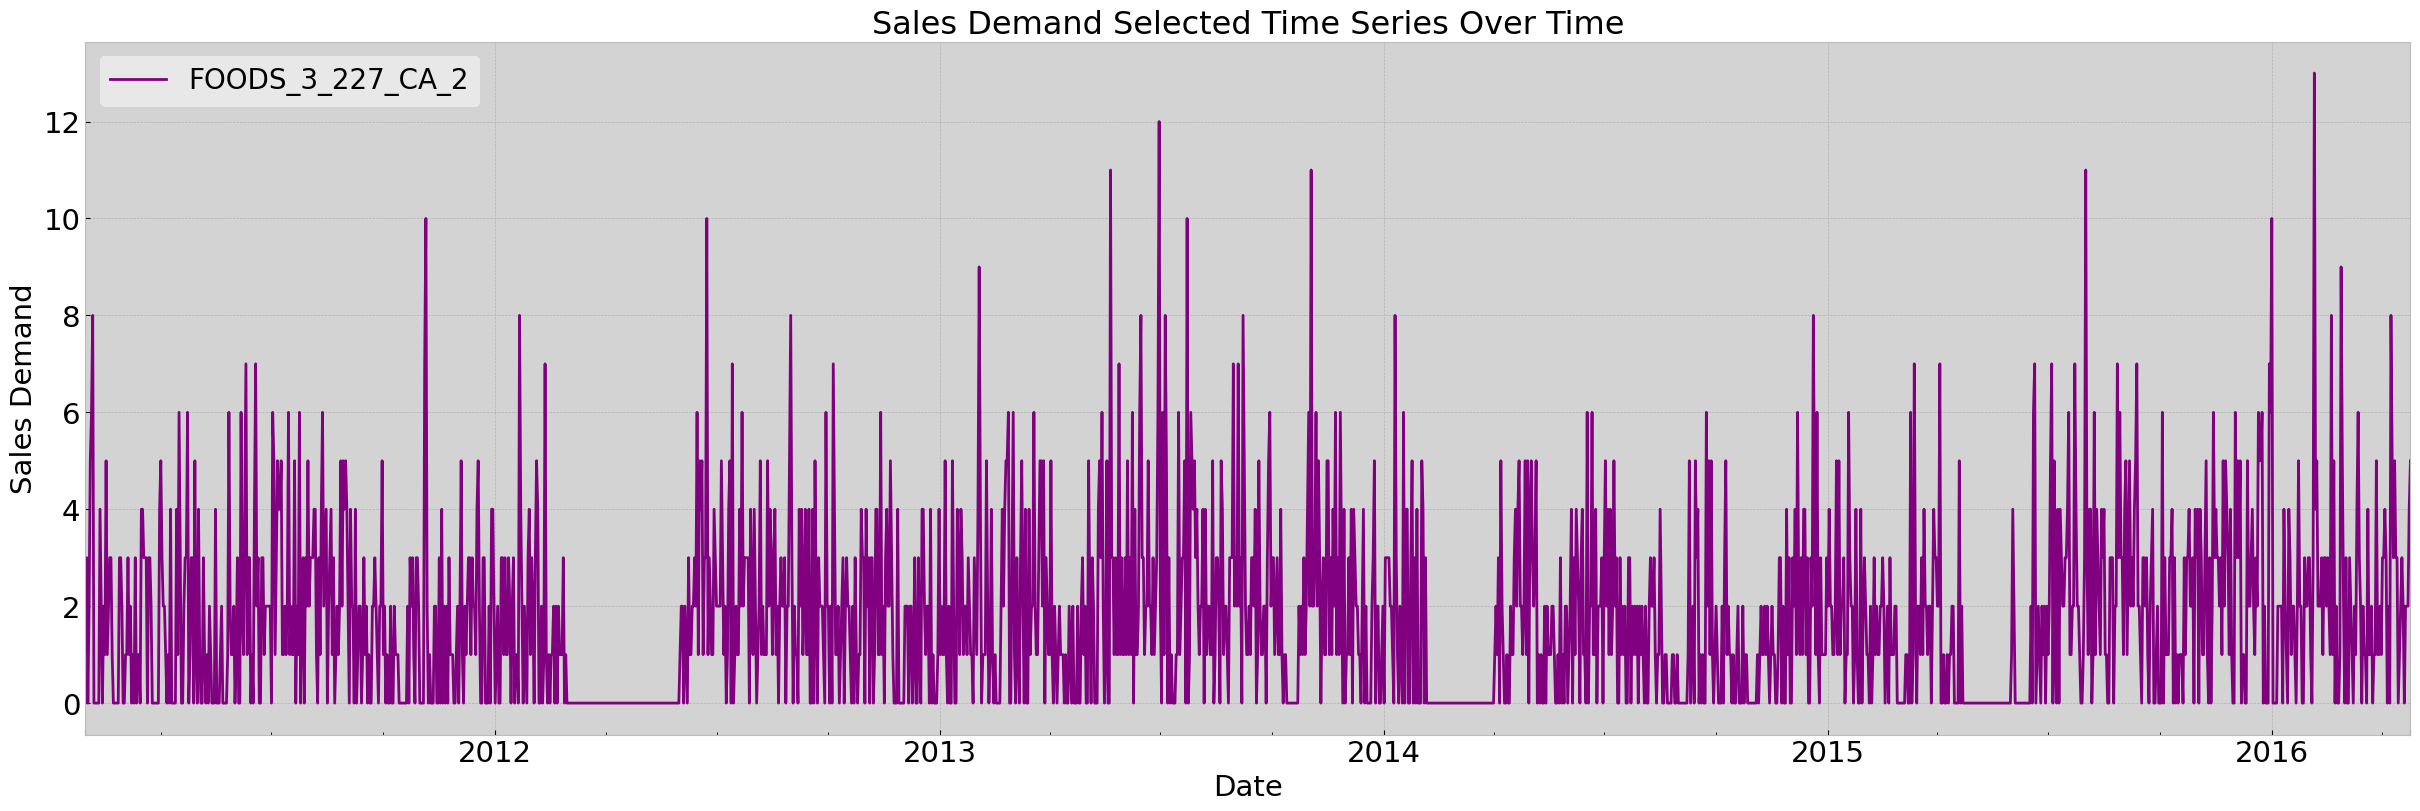

In [13]:
# Select an arbitrary index (for example, index 1200) from DF_Sales
index = 5500

# Create a DataFrame 'y' containing the time series data for the selected index
y = pd.DataFrame(DF_Sales.iloc[:, index])

# Set the index of 'y' to a list of dates
y = pd.DataFrame(y).set_index([dates_list])

# Assign the selected time series to 'TS_selected' for potential later use (not used in this code snippet)
TS_selected = y

# Convert the index of 'y' to datetime objects for better date handling
y.index = pd.to_datetime(y.index)

# Create a plot for the selected time series
ax = y.plot(figsize=(30, 9), color='purple')

# Set the background color of the plot area
ax.set_facecolor('lightgrey')

# Customize the x and y-axis labels and tick font sizes
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)

# Add a legend to the plot
plt.legend(fontsize=20)

# Set the plot title, y-axis label, and x-axis label
plt.title(label='Sales Demand Selected Time Series Over Time', fontsize=23)
plt.ylabel(ylabel='Sales Demand', fontsize=21)
plt.xlabel(xlabel='Date', fontsize=21)

# Display the plot
plt.show()

In [14]:
#Normalize data using the MinMaxScaler
data = np.array(y)
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_trained_data = scaler.fit_transform(data.reshape(-1, 1))

In [15]:
#Print values of normalized data to check if the values are between 0 and 1
print(normalized_trained_data[:5])
print(normalized_trained_data[-5:])

[[0.15384615]
 [0.23076923]
 [0.        ]
 [0.15384615]
 [0.38461538]]
[[0.15384615]
 [0.15384615]
 [0.15384615]
 [0.30769231]
 [0.38461538]]


To evaluate the distribution of data before and after the data is normalized, I will be plotting the distributions of the data.

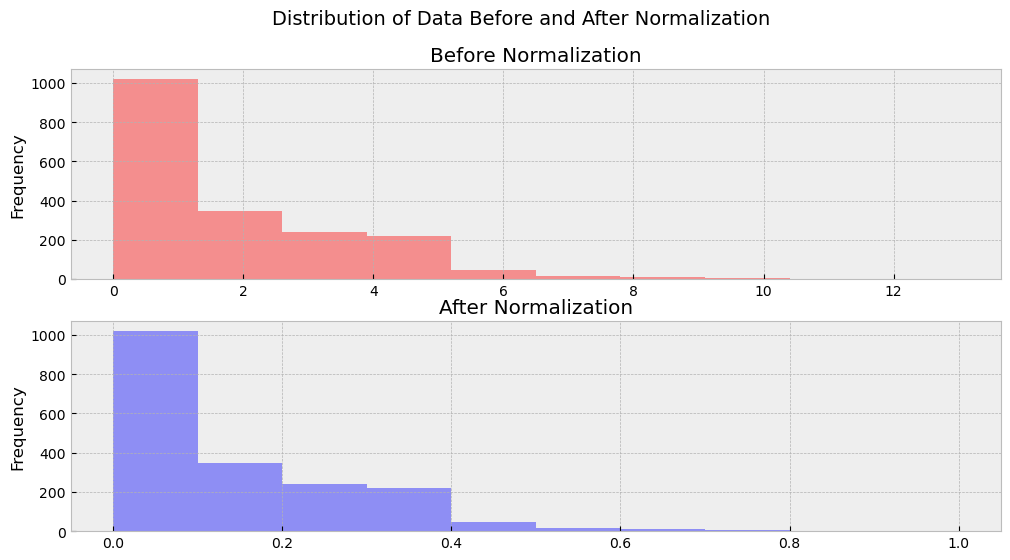

In [16]:
# Create a figure with two subplots
fig, axs = plt.subplots(2)

# Set the overall title for the figure
fig.suptitle('Distribution of Data Before and After Normalization', fontsize=14)

# Plot the histogram of data before normalization in the first subplot
pd.DataFrame(data).plot(kind='hist', ax=axs[0], alpha=0.4, figsize=[12, 6], legend=False, title='Before Normalization', color='red')

# Plot the histogram of data after normalization in the second subplot
pd.DataFrame(normalized_trained_data).plot(kind='hist', ax=axs[1], figsize=[12, 6], alpha=0.4, legend=False, title='After Normalization', color='blue')

# Display the figure with the subplots
plt.show()

As seen from the plot above the graphs are identical, eventhough the values of the data changed due to being normalized, the distribution of the data remains the same which means the data has not been tampered.

# Exploratory Data Analysis<a id="4"></a>

<h2 style="background-color:lightpink; color:black" >The Dataset</h2>
The M5 dataset, openly provided by Walmart, contains unit sales of numerous products offered in the United States, arranged as grouped time series. More specifically, the dataset includes the unit sales of 3,049 products divided into three product categories (Hobbies, Foods, and Household) and seven product departments, each of which is subdivided into the aforementioned categories.  The items are available in ten retailers across three states (CA, TX, and WI).
<img src='https://i.imgur.com/Ae5QBi9.png' style="width:500px;height:300px;">
The illustration above is a visualization illustrating the distribution of 3049 items across different aggregation levels.


<h2 style="background-color:lightpink; color:black" >Sold Items by Category</h2>
I'll be exploring on the amount of items sold by category. The items per category are an accumulation of items sold from each data and store across the states. The sold items are divided into three categories : Foods, Hobbies and Household. 

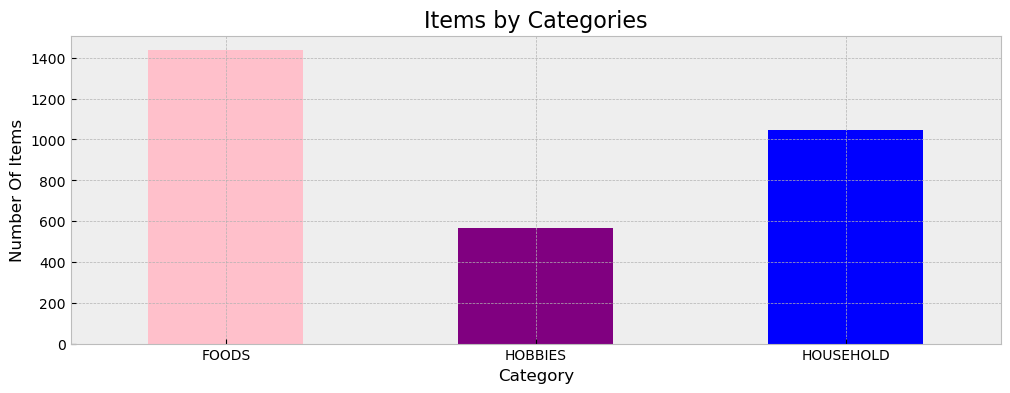

In [17]:
# Group the DataFrame by 'cat_id' and calculate the number of unique 'item_id' values in each group
grouped_data = sales_validation.groupby(['cat_id'])['item_id'].describe()['unique']

# Create a bar plot using the grouped data
ax = grouped_data.plot(
    kind='bar',            # Specify the type of plot as a bar plot
    figsize=(12, 4),       # Set the figure size
    color=['pink', 'purple', 'blue']  # Set the colors of the bars
)

# Set the title of the plot
ax.set_title("Items by Categories", fontsize=16)

# Set the label for the y-axis
ax.set_ylabel("Number Of Items", fontsize=12)

# Set the label for the x-axis
ax.set_xlabel("Category", fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=0)

# Display the plot
plt.show()

Based on the plot above some conclusions that can be drawn are :
- The item sold most across all states accumulated are items in the <b>Food</b> category.
- The item sold least across the states accumulated are items in the <b>Hobbies</b> category with a number almost reaching 600 items.
- The second most sold items are in the <b>Household</b> category at little over 1000 items being sold.


<h2 style="background-color:lightpink; color:black" >Sold Items by Department</h2>
I'll be exploring on the amount of items sold by department.After categorized into 3 main categories, the items are categorized into another 3 departments according to their use, function, etc. There are 2 departments each for both Household and Hobbies categories and 3 departments for the food category.

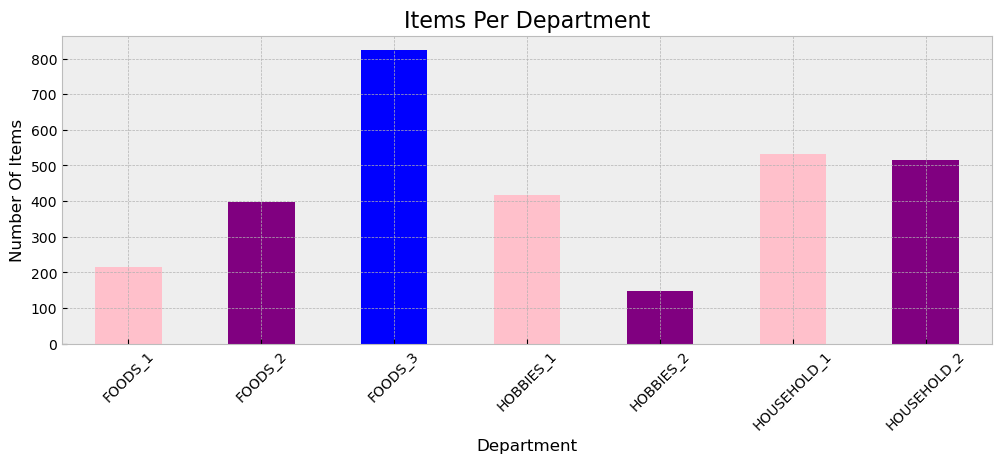

In [18]:
# Group the DataFrame by 'dept_id' and calculate the number of unique 'item_id' values in each group
grouped_data = sales_validation.groupby(['dept_id'])['item_id'].describe()['unique']

# Create a bar plot using the grouped data
ax = grouped_data.plot(
    kind='bar',                        # Specify the type of plot as a bar plot
    figsize=(12, 4),                   # Set the figure size
    color=['pink', 'purple', 'blue', 'pink', 'purple', 'pink', 'purple']  # Set custom colors for the bars
)

# Set the title of the plot
ax.set_title("Items Per Department", fontsize=16)

# Set the label for the y-axis
ax.set_ylabel("Number Of Items", fontsize=12)

# Set the label for the x-axis
ax.set_xlabel("Department", fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

Based on the plot above some conclusions that can be drawn are :
- The item sold most across all states accumulated are items in the <b>Food</b> category and specifically in the <b>FOODS_3</b> department.
- The difference in sales between the <b>Foods</b> category are pretty significant which are at approximately a little above 200 items, 400 items and a little over 800 items for each respective <b> FOODS_1, FOODS_2 and FOODS_3</b> departments
- The <b>Hobbies</b> category has a sharp difference in number of sales between the two departments at almost 200 units of items difference.
- The<b>Household</b> category has the most simillar amount of items sold in both departments with difference less than 50 units of items.



<h2 style="background-color:lightpink; color:black" >Time Series by Department</h2>
I'll be exploring on the amount of items sold by department and displaying them in a form of time series figure. Users will be able to pick a specific department and given the visualization of the corresponding department's sales overtime in each state and store. The seed parameter is used to control and reproduce random behavior (reproducibility), making the code's random selections predictable and consistent when needed.

In [19]:
# Create a dropdown widget to select a department
Department = widgets.Dropdown(
    options=list(sales_validation['dept_id'].unique()),  # List of department options
    value='HOBBIES_1',  # Default selected value
    style={'description_width': 'initial'},  # Set the description width
    description='Select Department:',  # Description label for the dropdown
)

# Function to plot random time series examples from the selected department
def Plot_Rand_TS_From_Department(Department, Seed=50):
    # Find columns in DF_Sales that contain the selected department
    col_index = DF_Sales.columns[DF_Sales.columns.str.contains(pat=Department)]

    # Set a random seed
    random.seed(Seed)

    # Select 24 random examples from the department
    examples_index = random.sample(list(col_index), 24)
    ts_sample = DF_Sales[examples_index]

    # Create subplots to display the time series examples
    fig, axs = plt.subplots(8, 3, figsize=(18, 22))
    axs = axs.flatten()
    ax_idx = 0
    for item in ts_sample.columns:
        ax = ts_sample[item].plot(
            title=item,
            fontsize=14,
            color=next(color_cycle),
            ax=axs[ax_idx]
        )
        ax.set_xlabel("Date", size=12)
        ax.set_ylabel("Item Sold", size=12)
        ax_idx += 1
    plt.tight_layout()
    plt.show()

# Create an interactive plot using the dropdown widget
plot = interactive(Plot_Rand_TS_From_Department, Department=Department, Seed=50)

# Display the interactive plot
plot

interactive(children=(Dropdown(description='Select Department:', options=('HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD…

Based on the plot above some conclusions that can be drawn are :
- All items sold in stores across the states have a varying sold number and is constantly changing with not persistent pattern. This indicates that the sales of particular items are abstract, but there are some items who have a fluctuative but still constant sale rate.
- When looking at most of the time series chart across all the departments <b>California (CA)</b> visualizes the most item being sold across all categories in comparison to the other 2 states.

<h2 style="background-color:lightpink; color:black" >Item Prices</h2>
I will be exploring the prices of items sold in Walmart by 2 weeks apart. I will be examining any price changes, which could possibly be affecting the urge of buyers to buy or not buy products and items.

In [20]:
# Create a dropdown widget to select a department
Department = widgets.Dropdown(
    options=list(sales_validation['dept_id'].unique()),  # List of department options
    value='HOBBIES_1',  # Default selected value
    style={'description_width': 'initial'},  # Set the description width
    description='Select Department:',  # Description label for the dropdown
)

# Function to plot random time series examples from the selected department
def Plot_Rand_TS_From_Department(Department, Seed=50):
    # Find columns in DF_Sales that contain the selected department
    col_index = DF_Sales.columns[DF_Sales.columns.str.contains(pat=Department)]

    # Set a random seed
    random.seed(Seed)

    # Select 24 random examples from the department
    examples_index = random.sample(list(col_index), 24)
    ts_sample = DF_Sales[examples_index]

    # Create subplots to display the time series examples
    fig, axs = plt.subplots(8, 3, figsize=(18, 22))
    axs = axs.flatten()
    ax_idx = 0
    for item in ts_sample.columns:
        ax = ts_sample[item].plot(
            title=item,
            fontsize=14,
            color=next(color_cycle),
            ax=axs[ax_idx]
        )
        ax.set_xlabel("Date", size=12)
        ax.set_ylabel("Item Sold", size=12)
        ax_idx += 1
    plt.tight_layout()
    plt.show()

# Create an interactive plot using the dropdown widget
plot = interactive(Plot_Rand_TS_From_Department, Department=Department, Seed=50)

# Display the interactive plot
plot

interactive(children=(Dropdown(description='Select Department:', options=('HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD…

Based on the plot above some conclusions that can be drawn are :
- Items in the <b>Hobbies</b>category rarely have a price change, in comparison to the other categories.
- Items sold in the <b>Foods</b> category has a lot of fluctuation in terms of pricing, this could possibly be due to the availability of fresh produce products, expiry date of items , and demand in a particular state.
- Simillar to the items in the Hobbies category, items in the <b>Household</b> category has minimal price changes probably due to long sell-by date, components of household items tend to stay the same as well.

<h2 style="background-color:lightpink; color:black" >Correlation</h2>
I will be using a HeatMap to visualize the correlation of items sold by department and category across all the stores in different states to see if a particular department has similarity in terms of sales. 

In [21]:
# Create a dropdown widget to select a department
Department = widgets.Dropdown(
    options=list(sales_validation['dept_id'].unique()),  # List of department options
    value='HOBBIES_1',  # Default selected value
    style={'description_width': 'initial'},  # Set the description width
    description='Select Department:',  # Description label for the dropdown
)

# Create a dropdown widget to select a store
Store = widgets.Dropdown(
    options=list(sales_validation['store_id'].unique()),  # List of store options
    value='CA_1',  # Default selected value
    style={'description_width': 'initial'},  # Set the description width
    description='Select Store:',  # Description label for the dropdown
)

# Function to calculate and plot the correlation heatmap
def calculate_correlation(Department, Store):
    # Copy the DF_Sales DataFrame for the selected department
    df_department = DF_Sales.copy(deep=True)
    df_department = df_department[df_department.columns[df_department.columns.str.contains(pat=Department)]]
    
    # Filter the DataFrame further to include only the selected store
    df_department = df_department[df_department.columns[df_department.columns.str.contains(pat=Store)]]

    # Calculate the correlation matrix
    corr_matrix = df_department.corr().abs()
    
    # Create a DataFrame containing the top correlated time series pairs
    sol = pd.DataFrame(corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
                     .stack()
                     .sort_values(ascending=False)).reset_index()

    # Select the top 10 correlated time series
    Top_TS = np.concatenate([sol.iloc[0:10]['level_0'].unique(), sol.iloc[0:10]['level_1'].unique()])
    df_department_top_corr = df_department[Top_TS]

    # Calculate the correlation matrix for the top correlated time series
    corr = df_department_top_corr.corr()
    matrix = np.triu(df_department_top_corr.corr())
    
    # Create and display the heatmap
    plt.figure(figsize=(15, 13))
    sns.heatmap(corr, annot=True, vmin=-1, vmax=1, center=0, cmap='magma', mask=matrix, cbar=False,
                xticklabels=corr.columns,
                yticklabels=corr.columns)
    plt.xticks(rotation=45) 
    print(sol.head(10))

# Create an interactive plot using the dropdown widgets
interactive(calculate_correlation, Department=Department, Store=Store)

interactive(children=(Dropdown(description='Select Department:', options=('HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD…

Based on the correlation plot above some conclusions that can be drawn are :
- Most <b> Food </b> products are interelated to each other meaning that when one person gets item A in CA_1 store they would be getting item B in the same store. This could be due to food being supplementary with each other. For example : Toast and Jam, when a person gets toast it is likely that one will be getting jam. 
- As seen on most of the <b>Hobbies</b> plot, it is rare to see the items being interrelated with each other. Hence there are lots of minus values on the heatmaps as shown above.
- Interestingly I found that the <b> Household</b> category has a simillar pattern to the Food category, whereas most items are correlated to each other. I believe that this could be due to the lifestyle of humans in doing grocery shopping. As in, when they are restocking for the month or a certain time period they will be getting all the products related to household such as Soap, Detergents, etc. 

# Feature Engineering <a id="5"></a>
Before we can apply machine learning methods, we must first reframe time series data as a supervised learning dataset.
In time series, there is no concept of input and output features. Instead, we must select the variable to be predicted and apply feature engineering to create all of the inputs that will be used to predict future time steps.
The purpose of feature engineering is to supply the supervised learning algorithm with strong and hopefully straightforward correlations between new input features and output features.


We will be selecting an arbitrary Time Series and combining item and store information into a unique identifier ('item_store_id') and reorganize the sales data into a DataFrame with dates as the index and item-store combinations as columns for further analysis or modeling.

In [22]:
# Filter calendar data to get only rows where 'weekday' is 'Monday'
calendar_weeks = calendar[calendar['weekday'] == 'Monday']

# Create a DataFrame 'calendar_index' containing 'date' and 'wm_yr_wk' columns
calendar_index = calendar_weeks[['date', 'wm_yr_wk']]

# Get unique values of 'wm_yr_wk' from the 'prices' DataFrame
unique_wm_yr_wk = prices['wm_yr_wk'].unique()

# Drop duplicate rows in 'calendar_index' based on the 'wm_yr_wk' column and reset the index
calendar_index = calendar_index.drop_duplicates(subset='wm_yr_wk').reset_index(drop=True)

# Merge 'calendar_index' with 'prices' based on the 'wm_yr_wk' column, using an outer join
prices_dates = prices.merge(calendar_index, on='wm_yr_wk', how='outer')

In [23]:
# Combine item id and store id 
prices_dates['item_store_id'] = prices_dates.apply(lambda x: x['item_id'] + '_' + x['store_id'], axis=1)

<h2 style="background-color:lightpink; color:black" >Creating Sequences</h2>
Rearranging the data into windows of sequences and labels is the fundamental concept behind Time Series Prediction and RNN (Recurrent Neural Network).In this part I will have to align the data into input features and labels with techniques which is adapted for Time series processing

I will be using a window or a series of 28 samples (28 days) for this project. I will create a sliding window which builds sequences and labels. In this case, we have sequences of 28 days, that will use to predict the next day.

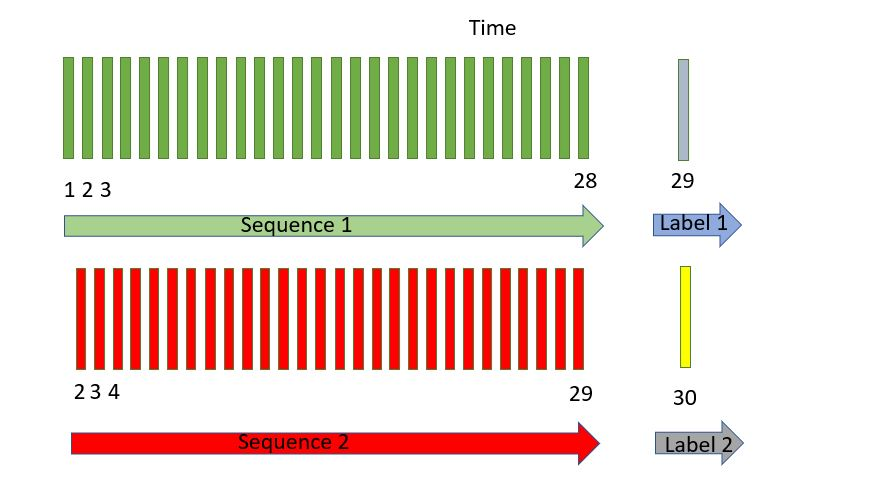

In [24]:
def rolling_window(data, seq_length):
    x = []  # List to store the input sequences
    y = []  # List to store the corresponding labels

    # Iterate through the data to create sequences
    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i + seq_length)]  # Extract a sequence of length 'seq_length'
        _y = data[i + seq_length]  # Extract the label for the next day
        x.append(_x)  # Append the sequence to 'x'
        y.append(_y)  # Append the label to 'y'

    # Convert 'x' and 'y' lists to NumPy arrays for further processing
    return np.array(x), np.array(y)


In [25]:
#Print data shape
seq_length = 28
x, y = rolling_window(normalized_trained_data, seq_length)
print(x.shape)
print(y.shape)

(1884, 28, 1)
(1884, 1)


# Splitting Data  <a id="6"></a>
Pytorch utilizes tensors as the input to the model. The variable acts as a wrapper to the tensor. As the starter of the model I use the variable wrapper first, however it is more common to train with batches and dataset class. I will also split the data to train and testing or validation sets. The method I am using here is the simple-hold out validation method where it reservs a portion of the data as a test set, and use the remaining data for training.

In [26]:
# Calculate the size of the training set (67% of the data)
train_size = int(len(y) * 0.7)

# Calculate the size of the testing set (remaining 30% of the data)
test_size = len(y) - train_size

# Convert the input sequences 'x' and labels 'y' into PyTorch tensors
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

# Create PyTorch tensors for the training data and labels
# Training data includes the first 'train_size' sequences
trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

# Create PyTorch tensors for the testing data and labels
# Testing data includes the remaining sequences starting from 'train_size'
testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [27]:
#Print train and test shape and label shape
print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

train shape is: torch.Size([1318, 28, 1])
train label shape is: torch.Size([1318, 1])
test shape is: torch.Size([566, 28, 1])
test label shape is: torch.Size([566, 1])


From the code above we can conclude that:
* There are 1318 sets of 28 samples each as the features (X) and 1318 labels as our target(y) in the training set 
* There are 566 sets of 28 samples with 566 labels in our tests set 

# Simple LSTM model <a id="7"></a>
I will be creating a simple Pytorch LSTM model with one LST layer and one dense input layer.
Note: that Pytorch has the nn.LSTM  function and nn.LSTMCell. I will be using the nn.LSTM function because it will automatically create multiple LSTM layer and it is more efficient to run.

The illustration below shows a chart of the simple LSTM model I am building :
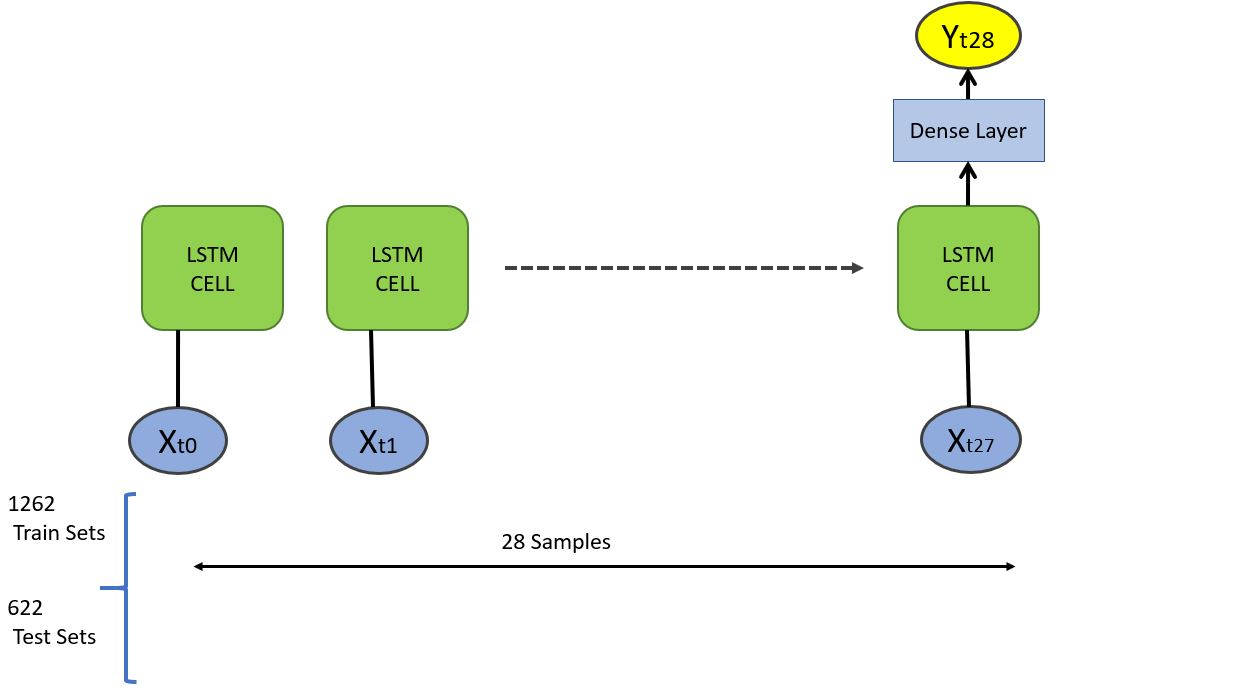

The following parameters are provided to the model:
* Num-classes - Number of output (in this case 1)
* Num layers - Number of layer ( in this case also 1)
* Input size - Number of input, (Given that we don't use batch, we have one input made of 28 samples)
* Hidden layers - Number of hidden layers in each cell (the more is better, but also will slow down the training)

In [28]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        # Define the number of output classes, input size, hidden size, and number of LSTM layers
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Define a dropout layer with a dropout rate of 0.2
        self.dropout = nn.Dropout(p=0.2)

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.25)

        # Define a fully connected (linear) layer to produce the final output
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialize the initial hidden state and cell state with zeros
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through the LSTM layer
        # 'ula' is the LSTM output sequence, 'h_out' is the hidden state
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        # Reshape the hidden state for the fully connected layer
        h_out = h_out.view(-1, self.hidden_size)

        # Pass the hidden state through the fully connected layer
        output = self.fc(h_out)

        # Apply dropout to the output
        output = self.dropout(output)

        return output

In [29]:
# Define a custom loss function for RMSE
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        # Create an instance of the Mean Squared Error (MSE) loss function
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, y):
        # Calculate the MSE loss between predicted and target values
        mse_loss = self.mse(yhat, y)
        
        # Calculate the square root of the MSE to obtain the RMSE
        rmse_loss = torch.sqrt(mse_loss)
        
        return rmse_loss

In [30]:
# Set Parameters
num_epochs = 500
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 1
num_classes = 1

# Define eval_interval (defines when to evaluate the model during training)
eval_interval = 10

# Initialize the LSTM model
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

# Move the model to the specified device (e.g., GPU if available)
lstm.to(device)

# Define the loss function (Mean Squared Error) and move it to the device
criterion = torch.nn.MSELoss().to(device)

# Define the optimizer (Adam) with a specified learning rate and weight decay
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=1e-5)

# Define a learning rate scheduler (ReduceLROnPlateau) to adjust learning rate during training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=500, factor=0.5, min_lr=1e-7, eps=1e-08)

# Train the model for the specified number of epochs
for epoch in progress_bar(range(num_epochs)):
    lstm.train()  # Set the model to training mode
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    
    # Calculate the loss and backpropagate
    loss = criterion(outputs, trainY.to(device))
    loss.backward()
    optimizer.step()

    # Evaluate the model on the test data at regular intervals
    if epoch % eval_interval == 0:
        lstm.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation for evaluation
            valid = lstm(testX.to(device))
            val_loss = criterion(valid, testY.to(device))
        scheduler.step(val_loss)  # Adjust learning rate based on validation loss

    # Print training and validation loss at regular intervals
    if epoch % 50 == 0:
        print("Epoch: %d, training loss: %1.5f, validation loss: %1.5f" % (epoch, loss.cpu().item(), val_loss.cpu().item()))


C:\Anaconda\envs\tf\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, training loss: 0.04572, validation loss: 0.03227
Epoch: 50, training loss: 0.02227, validation loss: 0.02151
Epoch: 100, training loss: 0.02312, validation loss: 0.02148
Epoch: 150, training loss: 0.02268, validation loss: 0.02157
Epoch: 200, training loss: 0.02160, validation loss: 0.02123
Epoch: 250, training loss: 0.02245, validation loss: 0.02099
Epoch: 300, training loss: 0.02206, validation loss: 0.02106
Epoch: 350, training loss: 0.02116, validation loss: 0.02075
Epoch: 400, training loss: 0.02191, validation loss: 0.02085
Epoch: 450, training loss: 0.02143, validation loss: 0.02076


<h2 style="background-color:lightpink; color:black" >Predict on Entire Dataset</h2>

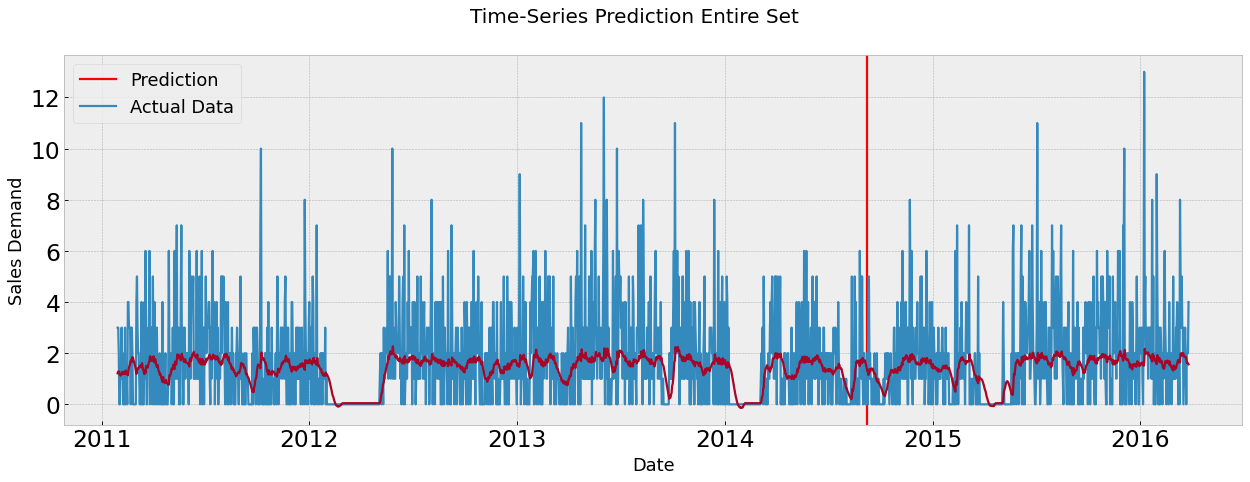

In [31]:
# Set the model to evaluation mode
lstm.eval()
with torch.no_grad():
    # Make predictions on the entire dataset
    train_predict = lstm(dataX.to(device))
    data_predict = train_predict.cpu().data.numpy()
    dataY_plot = dataY.data.numpy()

# Inverse Normalize the predicted and actual data
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

# Create DataFrames for the predicted and actual data with dates as the index
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])  # Exclude the last 29 dates
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])  # Exclude the last 29 dates

# Plot the results
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')  # Vertical line to indicate the split between training and testing data
plt.plot(df_labels[0])  # Plot the actual data
plt.plot(df_predict[0])  # Plot the predicted data
plt.legend(['Prediction', 'Actual Data'], fontsize=16)
plt.suptitle('Time-Series Prediction Entire Set', fontsize=18)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.ylabel(ylabel='Sales Demand', fontsize=16)
plt.xlabel(xlabel='Date', fontsize=16)
plt.show()

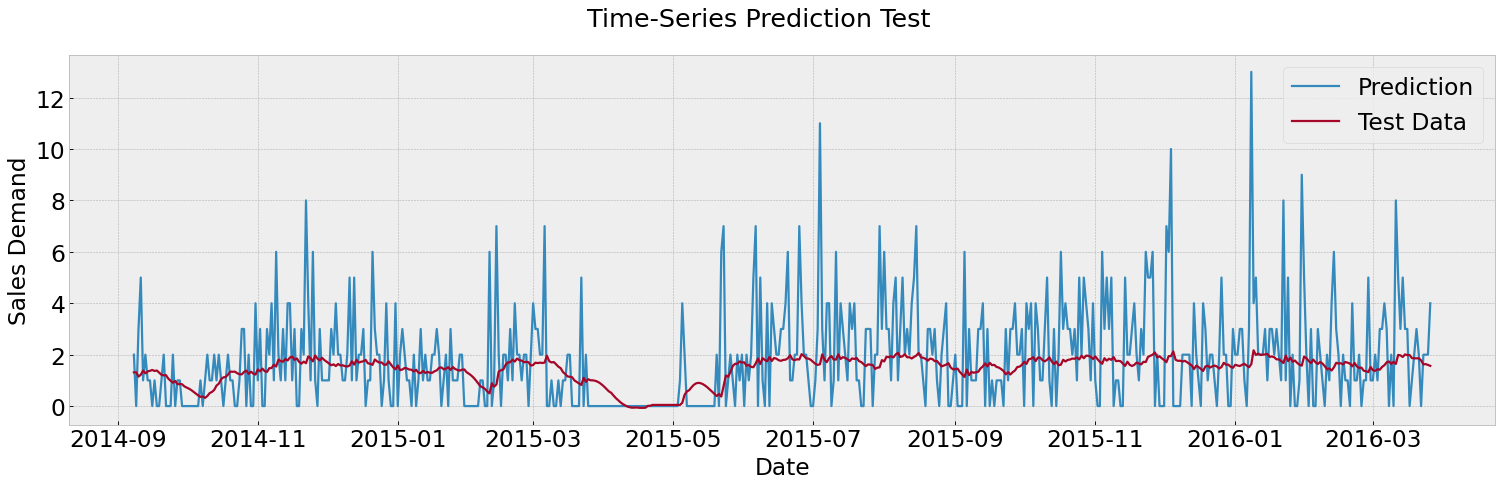

In [32]:
#Plot Test Set
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Test Data'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

<h2 style="background-color:lightpink; color:black" >Calculate Performance Metrics</h2>

In [33]:
# Calculate RMSE
rmse_singleLayer = np.sqrt(mean_squared_error(dataY_plot[-testX.size()[0]:], data_predict[-testX.size()[0]:]))

# Calculate R^2
r2_singleLayer = r2_score(dataY_plot[-testX.size()[0]:], data_predict[-testX.size()[0]:])

# Calculate MAE
mae_singleLayer = mean_absolute_error(dataY_plot[-testX.size()[0]:], data_predict[-testX.size()[0]:])

# Create a DataFrame
results_singleLayer = pd.DataFrame({'Metric': ['RMSE', 'R^2', 'MAE'],
                            'Value': [rmse_singleLayer, r2_singleLayer, mae_singleLayer]})

# Display the DataFrame
results_singleLayer

,Metric,Value
0,RMSE,1.878877
1,R^2,0.053674
2,MAE,1.329708


Given the results of the graph as well as RMSE value, we can conclude that:
- The square root of the average of the squared differences between the predicted values and the actual value is approximately 0.447 which is quite impressive.
- The model could yield approximate and simillar trend however not exact and still needs lots of fine tuning. 
- Model could not capture all of the sudden and sharp changes in sales.

# Multiple LSTM layers Model <a id="8"></a> 
Given the results of the simple LSTM model not performing well, I will be using multiple LSTM Layers to enhance the model. The scheme below shows the Multiple LSTM layers model in illustration: 
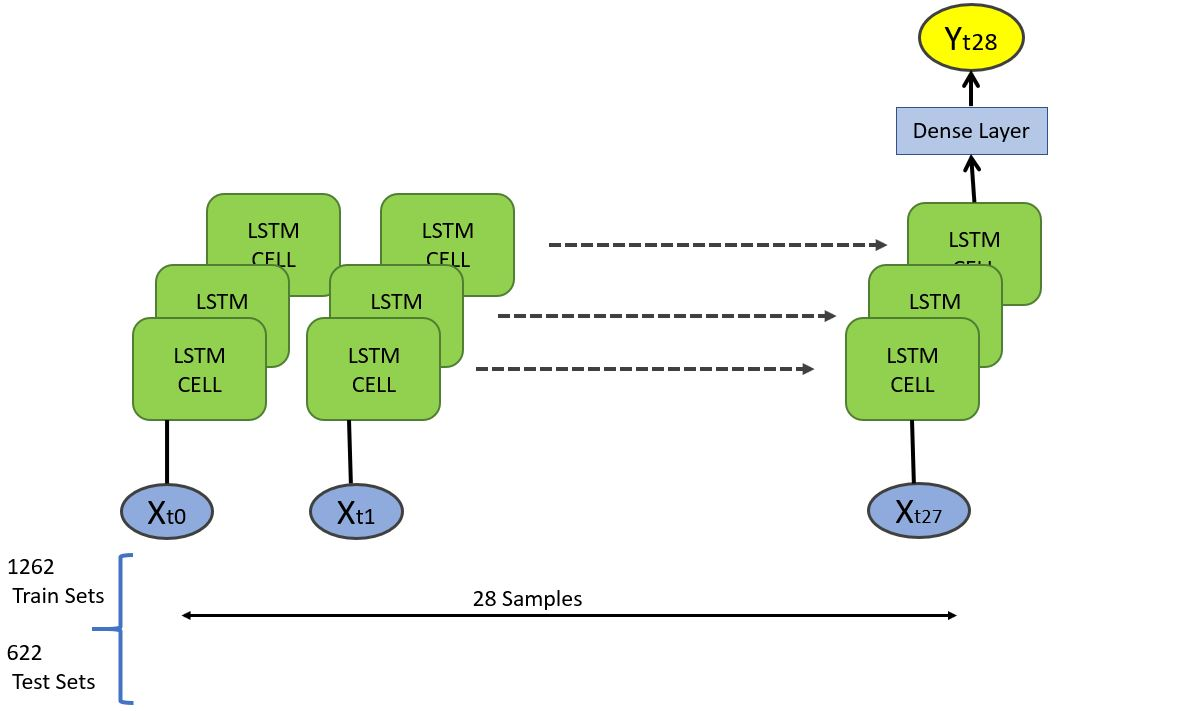

In [34]:
class MultipleLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(MultipleLSTM, self).__init__()

        # Define the number of output classes, input size, hidden size, and number of LSTM layers
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Set the batch size (default is 1)
        self.batch_size = 1

        # Define the LSTM layers
        self.MultipleLSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.25)

        # Define a fully connected (linear) layer to produce the final output
        self.fc = nn.Linear(hidden_size, num_classes)

        # Define a dropout layer with a dropout rate of 0.2
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # Initialize the initial hidden state and cell state with zeros
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))

        # Propagate input through the LSTM layers
        _, (hn, cn) = self.MultipleLSTM(x, (h_1, c_1))

        # Reshape the hidden state
        y = hn.view(-1, self.hidden_size)

        # Get the final state of the LSTM layers
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]

        # Pass the final state through the fully connected layer
        output = self.fc(final_state)

        return output

In [35]:
def init_weights(m):
    # Iterate through named parameters of the model
    for name, param in m.named_parameters():
        # Initialize the parameter data with random values from a uniform distribution
        # The range of values is -0.08 to 0.08
        nn.init.uniform_(param.data, -0.08, 0.08)

In [36]:
# Set Parameters
num_epochs = 500
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 2  # Number of LSTM layers
num_classes = 1

# Initialize the MultipleLSTM model
lstm = MultipleLSTM(num_classes, input_size, hidden_size, num_layers)

# Move the model to the specified device (e.g., GPU if available)
lstm.to(device)

# Initialize the model's weights using the custom init_weights function
lstm.apply(init_weights)

# Define the loss function (Mean Squared Error) and move it to the device
criterion = torch.nn.MSELoss().to(device)

# Define the optimizer (Adam) with a specified learning rate and weight decay
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=1e-5)

# Define a learning rate scheduler (ReduceLROnPlateau) to adjust learning rate during training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5, min_lr=1e-7, eps=1e-08)

# Train the model for the specified number of epochs
for epoch in progress_bar(range(num_epochs)):
    lstm.train()  # Set the model to training mode
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad();
    torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)  # Clip gradients to avoid exploding gradients

    # Calculate the loss and backpropagate
    loss = criterion(outputs, trainY.to(device))
    loss.backward()
    
    # Adjust learning rate based on training loss
    scheduler.step(loss)
    optimizer.step()
    
    # Use torch.no_grad() for validation
    lstm.eval()
    with torch.no_grad():
        valid = lstm(testX.to(device))
        vall_loss = criterion(valid, testY.to(device))
    
    # Adjust learning rate based on validation loss
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
        print("Epoch: %d, loss: %1.5f valid loss: %1.5f" % (epoch, loss.cpu().item(), vall_loss.cpu().item()))


Epoch: 0, loss: 0.02088 valid loss: 0.48771
Epoch: 50, loss: 0.01978 valid loss: 0.02141
Epoch: 100, loss: 0.01820 valid loss: 0.02016
Epoch: 150, loss: 0.01812 valid loss: 0.02005
Epoch: 200, loss: 0.01808 valid loss: 0.02000
Epoch: 250, loss: 0.01805 valid loss: 0.01997
Epoch: 300, loss: 0.01798 valid loss: 0.01997
Epoch: 350, loss: 0.01801 valid loss: 0.02006
Epoch: 400, loss: 0.01797 valid loss: 0.02010
Epoch: 450, loss: 0.01791 valid loss: 0.01994


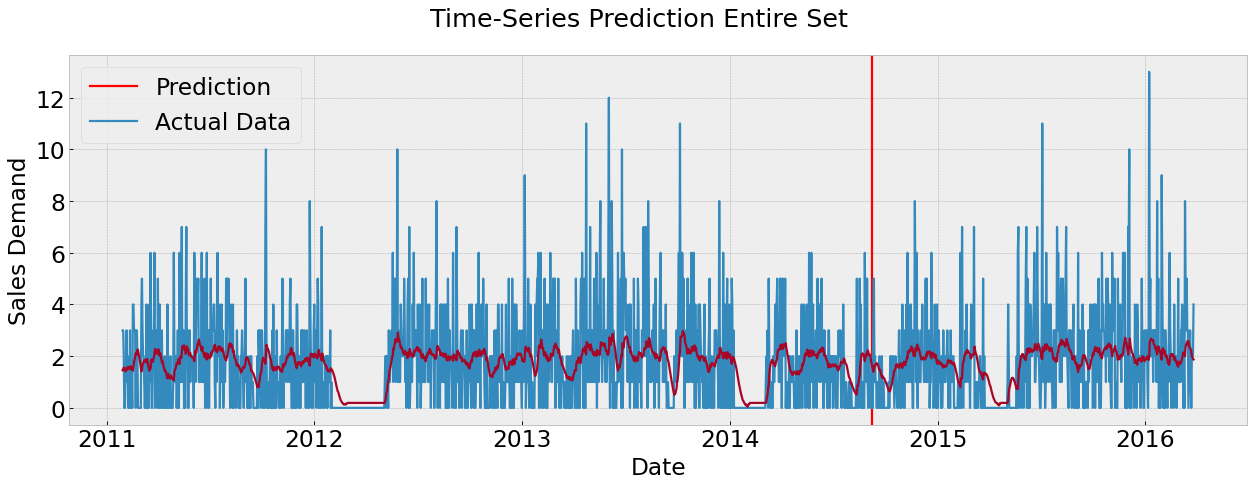

In [37]:
# Set the model to evaluation mode
lstm.eval()
with torch.no_grad():
    # Make predictions on the entire dataset
    train_predict = lstm(dataX.to(device))
    data_predict = train_predict.cpu().data.numpy()
    dataY_plot = dataY.data.numpy()

# Inverse Normalize the predicted and actual data
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

# Create DataFrames for the predicted and actual data with dates as the index
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])  # Exclude the last 29 dates
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])  # Exclude the last 29 dates

# Plot the results
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')  # Vertical line to indicate the split between training and testing data
plt.plot(df_labels[0])  # Plot the actual data
plt.plot(df_predict[0])  # Plot the predicted data
plt.legend(['Prediction', 'Actual Data'], fontsize=21)
plt.suptitle('Time-Series Prediction Entire Set', fontsize=23)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.ylabel(ylabel='Sales Demand', fontsize=21)
plt.xlabel(xlabel='Date', fontsize=21)
plt.show()


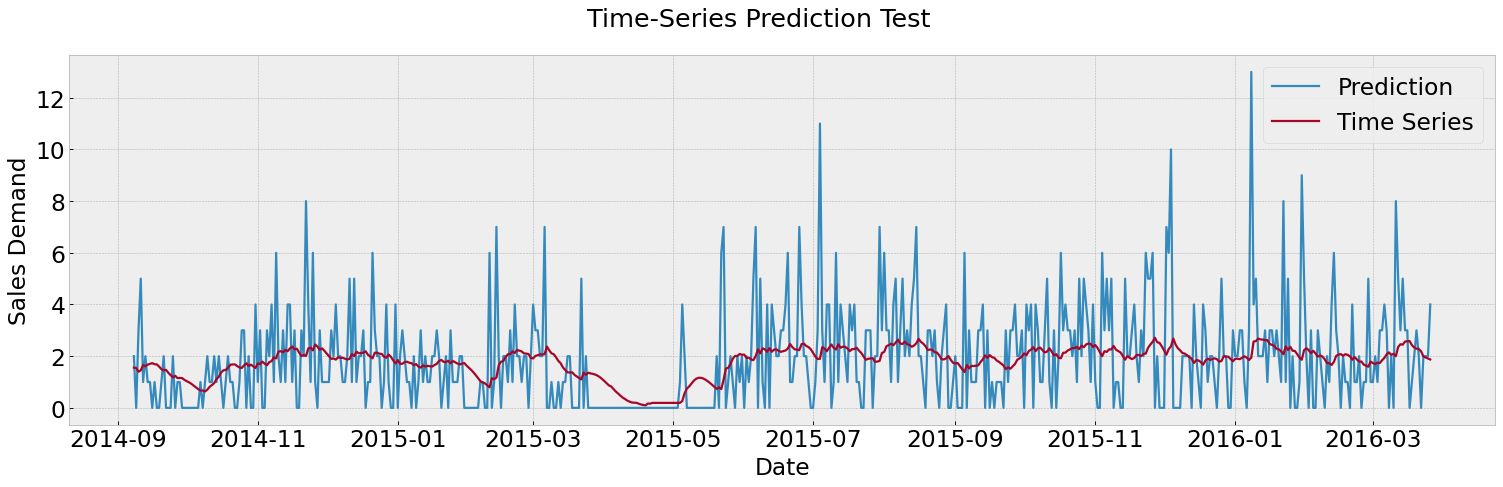

In [38]:
#Plot Test Set 
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

<h2 style="background-color:lightpink; color:black" >Calculate Performance Metrics</h2>

In [39]:
# Calculate RMSE
rmse_multiLayer = np.sqrt(mean_squared_error(dataY_plot[-testX.size()[0]:], data_predict[-testX.size()[0]:]))

# Calculate R^2
r2_multiLayer = r2_score(dataY_plot[-testX.size()[0]:], data_predict[-testX.size()[0]:])

# Calculate MAE
mae_multiLayer = mean_absolute_error(dataY_plot[-testX.size()[0]:], data_predict[-testX.size()[0]:])

# Create a DataFrame
results_multiLayer = pd.DataFrame({'Metric': ['RMSE', 'R^2', 'MAE'],
                            'Value': [rmse_multiLayer, r2_multiLayer, mae_multiLayer]})

# Display the DataFrame
results_multiLayer

,Metric,Value
0,RMSE,1.837196
1,R^2,0.095194
2,MAE,1.347971


Based on the graphs and calculated RMSE value for the Multiple Layers LSTM Model, it has a minor improvement with a difference of 0.01 at the RMSE value. However, there is drastic change in terms of graph, as there are less points which are not simillar to the actual trend. The R squared value is negative indicating that the model is doing poorly.

# Adding More Features<a id="9"></a> 
Up until now, we've incorporated just one element, which is the Sales demand, in order to improve the prediction model's effectiveness. To enhance its performance further, let's introduce additional features. Features can be lags or rolling windows.  

I will start again with the selected Time Series, Add some features and modify a bit our model and training.

In [40]:
# Re-Use the Time Series we have selected earlier
DF = TS_selected
colnames = DF.columns
DF = DF.rename(columns={colnames[0]:'sales'})
DF.tail()

,sales
2016-04-20,2
2016-04-21,2
2016-04-22,2
2016-04-23,4
2016-04-24,5


<h2 style="background-color:lightpink; color:black" >Introducing Lags</h2>

Lag features, also known as time-shifted features, are produced by shifting variable values backward in time. They are valuable for capturing temporal dependencies and trends in time-series data because they capture the past values of a variable. In time-series research and forecasting, lag features are often employed to incorporate previous data into models. You can capture patterns, seasonality, and autocorrelation in the data by including lag features such as lag 1, lag 2, and so on. The quantity and type of lag features used are determined by the dataset and patterns of interest.

I will be introducing lags to the the target column `sales`. The lags I introduced are from range of 1 day, 7 days, 14 days, 28 days and a year. It creates new columns in the dataframe for each shift value that represent the sales data shifted by the corresponding number of days.

In [41]:
start_time = time.time()

# Iterate over different time lags (1, 7, 14, 28, 365)
for i in (1, 7, 14, 28, 365):
    print('Shifting:', i)
    
    # Create a new column in the DataFrame by shifting the 'sales' column by the specified lag 'i'
    DF['lag_'+str(i)] = DF['sales'].transform(lambda x: x.shift(i))

# Calculate and print the time taken for bulk shifting
print('%0.2f min: Time for bulk shift' % ((time.time() - start_time) / 60))

Shifting: 1
Shifting: 7
Shifting: 14
Shifting: 28
Shifting: 365
0.00 min: Time for bulk shift


<h2 style="background-color:lightpink; color:black" >Visualize Lags</h2>
We should create a plot to visualize the time series lags. While it might be challenging to discern small lags due to the short duration of the time series, longer lags like 365 days should create more noticeable shifts.

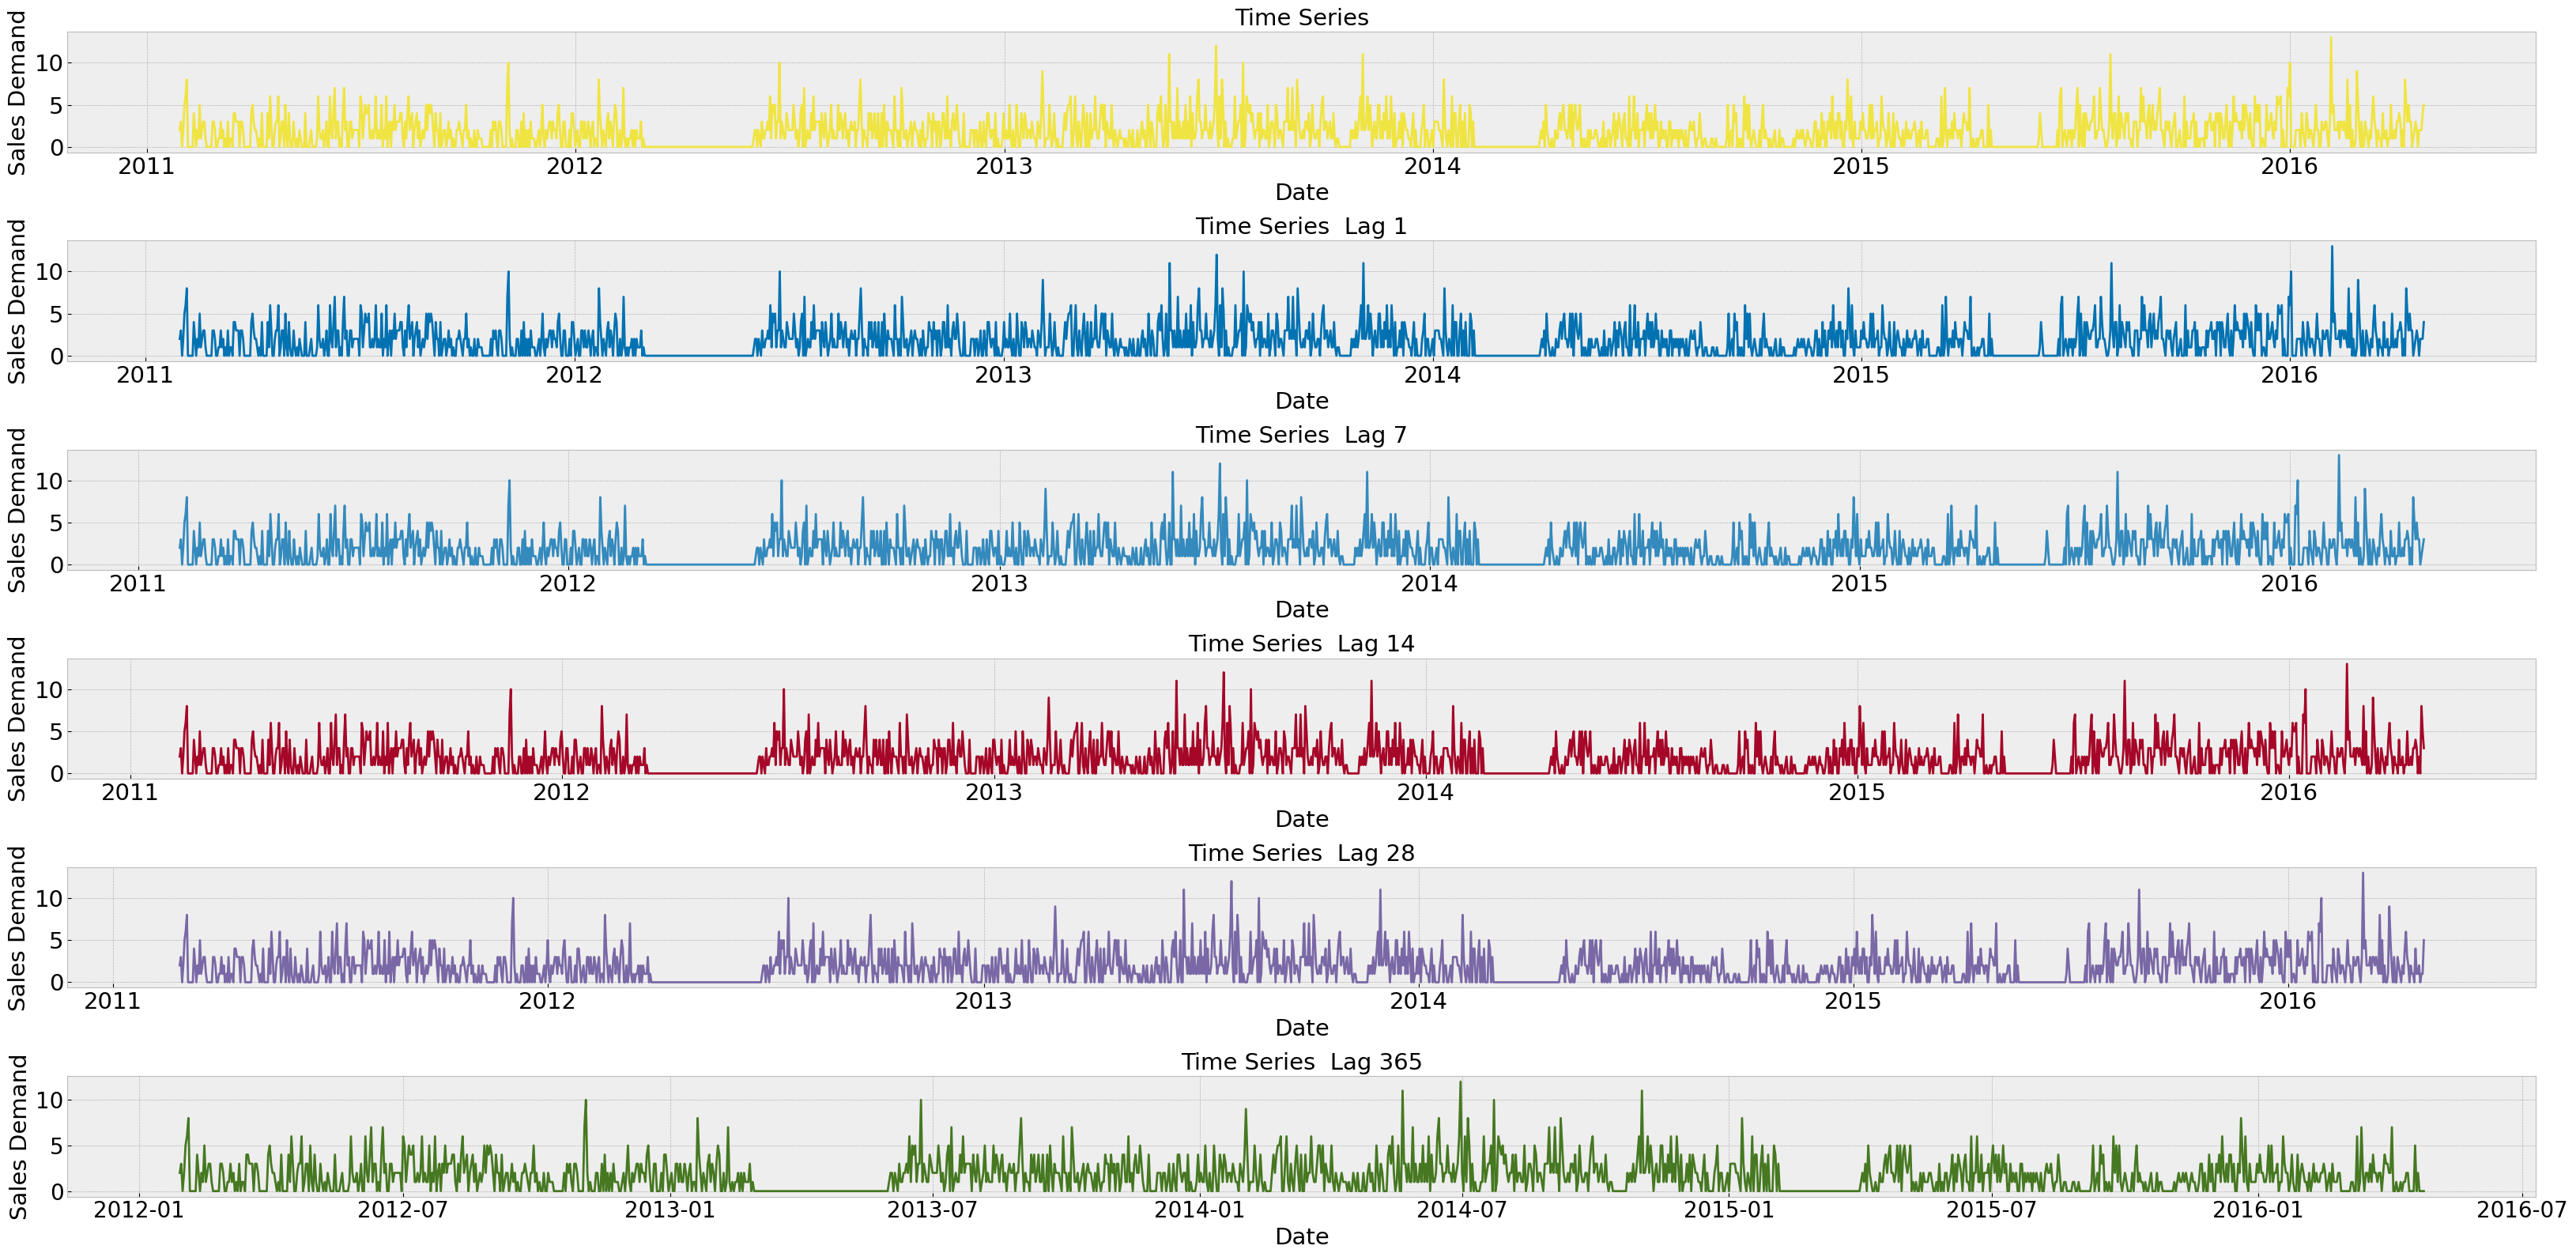

In [42]:
# Set the DataFrame index to 'dates_list'
DF = DF.set_index([dates_list])

# Define a product label (can be customized)
Product = "Time Series"

# Create a figure with 6 subplots arranged in 6 rows and 1 column
fig, axs = plt.subplots(6, 1, figsize=(33, 16))
axs = axs.flatten()  # Flatten the 2D array of subplots into a 1D array
ax_idx = 0

# Iterate over lag values (0, 1, 7, 14, 28, 365)
for i in (0, 1, 7, 14, 28, 365):
    if i == 0:
        # For lag 0, plot the original 'sales' column
        ax = DF['sales'].plot(fontsize=21,
                              legend=False,
                              color=next(color_cycle),
                              ax=axs[ax_idx])
        ax.set_ylabel("Sales Demand", fontsize=21)
        ax.set_xlabel("Date", fontsize=21)
        ax.set_title(fontsize=21, label=Product)
        ax_idx += 1
    else:
        # For other lag values, plot the corresponding 'lag_i' column
        ax = DF[f'lag_{i}'].plot(fontsize=21,
                                  legend=False,
                                  color=next(color_cycle),
                                  ax=axs[ax_idx])
        ax.set_ylabel("Sales Demand", fontsize=21)
        ax.set_xlabel("Date", fontsize=21)
        ax.set_title(fontsize=21, label=Product+f'  Lag {i}')
        ax_idx += 1

# Customize tick label fonts
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Adjust layout for better visualization
plt.tight_layout()

# Display the subplots
plt.show()

As seen from the graph above, the smaller lag shifts has subtle changes that is hard to detect however, we can clearly see the shift of the data in the 365 one. The chart is slightly shifted to the right hand side. 

<h2 style="background-color:lightpink; color:black" >Rolling Windows</h2>
This method is called the rolling window method because the window would be different for every data point.I'll compute a weekly rolling average of the products sold. More features, such as rolling min, max, and sum, can be calculated.For rolling windows, we will use mean and std (standard deviation)

In [43]:
# Iterate over different rolling periods (7, 14, 28, 60, 180, 365)
for i in [7, 14, 28, 60, 180, 365]:
    print('Rolling period:', i)
    
    # Calculate the rolling mean for the 'sales' column with a shift and rolling window of 'i'
    DF['rolling_mean_'+str(i)] = DF['sales'].transform(lambda x: x.shift(28).rolling(i).mean())
    
    # Calculate the rolling standard deviation for the 'sales' column with a shift and rolling window of 'i'
    DF['rolling_std_'+str(i)]  = DF['sales'].transform(lambda x: x.shift(28).rolling(i).std())

# Calculate and print the time taken for the loop
print('%0.2f min: Time for loop' % ((time.time() - start_time) / 60))

# Display the first few rows of the DataFrame with the newly added rolling statistics
DF.head()

Rolling period: 7
Rolling period: 14
Rolling period: 28
Rolling period: 60
Rolling period: 180
Rolling period: 365
0.03 min: Time for loop


,sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
2011-01-29,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-30,3,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-31,0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-01,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-02,5,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The result of applying lags and rolling windows created NAN values in the data, when training with this data it will impact towards the loss value being NAN as well. To solve this I will be filling in the NAN values with zero. 

In [44]:
# Replace 'nan' with actual NaN values (numpy.nan)
DF = DF.replace('nan', np.nan)

# Fill any remaining NaN values with 0
DF = DF.fillna(0)

# Display the first few rows of the cleaned DataFrame
DF.head()

,sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
2011-01-29,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-30,3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-31,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-01,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-02,5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h2 style="background-color:lightpink; color:black" >Normalization of Data</h2> 
To address the multi-dimensionality of the data, we can normalize the entire data frame. However, when it comes to the target variable (sales), we should apply a separate normalization method since our prediction will be one-dimensional. This means we need to normalize the features (independent variables) and the target variable (sales) differently to ensure that they are on the same scale while preserving the necessary characteristics for prediction.

In [45]:
# Make a deep copy of the original DataFrame
DF_normalized = DF.copy(deep=True)

# Initialize a MinMaxScaler for feature scaling (independent variables)
scaler = MinMaxScaler(feature_range=(0, 1))

# Initialize a MinMaxScaler for scaling the target variable 'sales' (dependent variable)
y_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale all features (independent variables) in the DataFrame
scaled_data = scaler.fit_transform(DF)

# Fit the y_scaler to the 'sales' column in the original DataFrame
y_scaler.fit_transform(DF['sales'].values.reshape(-1, 1))

# Update the values in the DF_normalized DataFrame with the scaled_data
DF_normalized.iloc[:, :] = scaled_data

# Display the first few rows of the normalized DataFrame
DF_normalized.head()

,sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
2011-01-29,0.153846,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-30,0.230769,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-31,0.000000,0.230769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-01,0.153846,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-02,0.384615,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h2 style="background-color:lightpink; color:black" >Using Categorical Embeddings</h2>
I've drawn inspiration from an informative article I came across (https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9) on the concept of using categorical embeddings, and I'm eager to apply this approach to my project.

Specifically, I've decided to implement it in the context of representing days of the week. Instead of treating days as nominal categorical variables, I will convert them into four-dimensional vectors, each capturing unique characteristics of a day. 

This transformation allows me to introduce a sense of continuity and order into my dataset, making it more suitable for machine learning models. By creating a mapping of days to integers, employing an embedding layer with a four-dimensional output in my model, and fine-tuning these embeddings during training, I aim to harness the power of categorical embeddings to enhance the predictive capabilities of my machine learning algorithm. This novel approach promises to reveal intricate relationships and patterns within the data that might otherwise be overlooked."

To incorporate the day of the week into our analysis, we will have to merge data from the calendar DataFrame into our existing dataset.

In [46]:
# Reset the index to make 'date' a regular column
DF_normalized = DF_normalized.reset_index()

# Rename the 'index' column to 'date'
DF_normalized = DF_normalized.rename(columns={'index':'date'})

# Convert the 'date' column to datetime objects
DF_normalized['date'] = pd.to_datetime(DF_normalized['date'])

# Format the 'date' column to have a consistent YYYY-MM-DD string format
DF_normalized['date'] = DF_normalized['date'].apply(lambda x: x.strftime("%Y-%m-%d"))

# Remove duplicate rows based on the 'date' column in the DF_normalized DataFrame
DF_normalized = DF_normalized.drop_duplicates(subset='date')

# Remove duplicate rows based on the 'date' column in the 'calendar' DataFrame
calendar = calendar.drop_duplicates(subset='date')

# Merge the 'calendar' DataFrame with the 'DF_normalized' DataFrame based on the 'date' column
DF_normalized = DF_normalized.merge(calendar[['date', 'weekday']], on='date')

# Display the first few rows of the updated 'DF_normalized' DataFrame
DF_normalized.head()

,date,sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365,weekday
0,2011-01-29,0.153846,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Saturday
1,2011-01-30,0.230769,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sunday
2,2011-01-31,0.000000,0.230769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Monday
3,2011-02-01,0.153846,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Tuesday
4,2011-02-02,0.384615,0.153846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wednesday


In [47]:
#Adding embedded factors
DF_normalized['wd1'] = 0
DF_normalized['wd2'] = 0
DF_normalized['wd3'] = 0
DF_normalized['wd4'] = 0

# Define the conditions for each day of the week
conditions = [
    DF_normalized['weekday'] == 'Sunday',
    DF_normalized['weekday'] == 'Monday',
    DF_normalized['weekday'] == 'Tuesday',
    DF_normalized['weekday'] == 'Wednesday',
    DF_normalized['weekday'] == 'Thursday',
    DF_normalized['weekday'] == 'Friday',
    DF_normalized['weekday'] == 'Saturday'
]

# Define the values for each condition
values = [
    (0.4, -0.3, 0.6, 0.1),
    (0.2, 0.2, 0.5, -0.3),
    (0.1, -1.0, 1.3, 0.9),
    (-0.6, 0.5, 1.2, 0.7),
    (0.9, 0.2, -0.1, 0.6),
    (0.4, 1.1, 0.3, -1.5),
    (0.3, -0.2, 0.6, 0.0)
]

# Loop through conditions and values to assign values to respective columns
for condition, value in zip(conditions, values):
    DF_normalized.loc[condition, ['wd1', 'wd2', 'wd3', 'wd4']] = value


Let's compare the values of one example before and after normalization to verify that the normalization was done correctly.

<Axes: title={'center': 'After Normalization'}, ylabel='Frequency'>

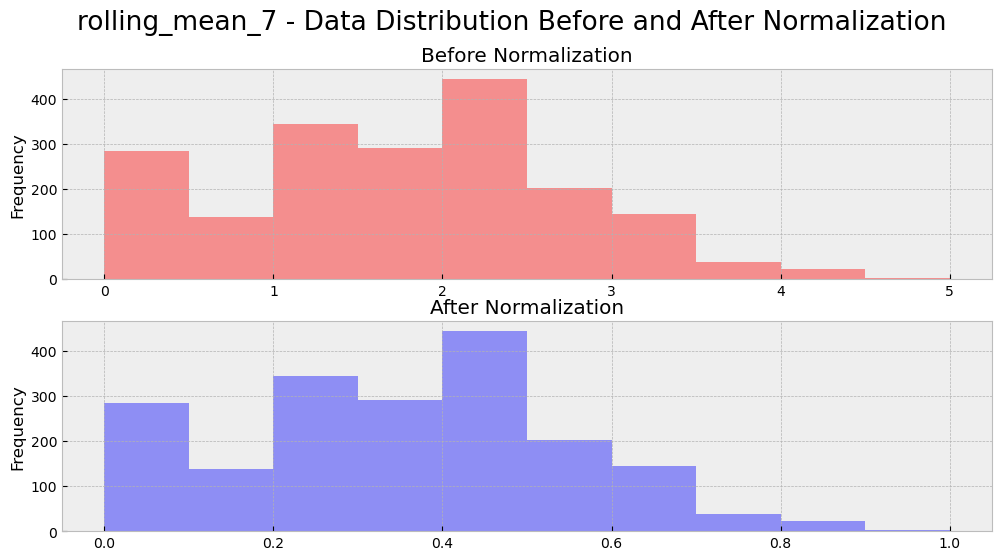

In [48]:
# Create a figure with 2 subplots arranged vertically (2 rows)
fig, axs = plt.subplots(2)

# Set the title for the entire figure
fig.suptitle('rolling_mean_7 - Data Distribution Before and After Normalization', fontsize=19)

# Plot the histogram of 'rolling_mean_7' before normalization in the first subplot (axs[0])
pd.DataFrame(DF['rolling_mean_7']).plot(kind='hist', ax=axs[0], alpha=0.4, figsize=[12, 6], legend=False, title='Before Normalization', color='red')

# Plot the histogram of 'rolling_mean_7' after normalization in the second subplot (axs[1])
pd.DataFrame(DF_normalized['rolling_mean_7']).plot(kind='hist', ax=axs[1], figsize=[12, 6], alpha=0.4, legend=False, title='After Normalization', color='blue')

<h2 style="background-color:lightpink; color:black" >Multi-Dimensional Sliding Window</h2>
This is essentially a more complex variation of the rolling window technique. In the case of a rolling window, the size of the window remains constant while it travels ahead in time. As a result, we examine only the most current data and disregard previous values. The function below creates a sliding window or sequences of 28 days and one day label for multiple features.

In [49]:
def sliding_windows_mutli_features(data, seq_length):
    x = []  # List to store input sequences
    y = []  # List to store corresponding labels

    for i in range((data.shape[0]) - seq_length - 1):
        _x = data[i:(i + seq_length), :]  # Extract a sequence of 'seq_length' days, where each day has 16 feature columns
        _y = data[i + seq_length, 0]  # Extract the label from the next day (column 0 contains the label)
        x.append(_x)  # Append the input sequence to 'x'
        y.append(_y)  # Append the label to 'y'

    return np.array(x), np.array(y).reshape(-1, 1)

In [50]:
# Select only the features and the target for prediction  
data_with_features = DF_normalized[["sales","lag_7","lag_1","lag_28","lag_365","rolling_mean_7",\
"rolling_std_7","rolling_mean_14","rolling_std_14","rolling_mean_28","rolling_std_28","rolling_mean_60","rolling_std_60",'lag_28','wd1','wd2','wd3','wd4']].to_numpy()             

data_with_features.shape

(1913, 18)

Now will be creating the multiple features sliding window dataset

In [51]:
# Call the sliding_windows_mutli_features function to create input sequences (x) and labels (y)
x, y = sliding_windows_mutli_features(data_with_features, seq_length=28)

# Print the shape of the input sequences (x) and labels (y)
print("X_data shape is", x.shape)
print("y_data shape is", y.shape)

X_data shape is (1884, 28, 18)
y_data shape is (1884, 1)


# Final LSTM Model <a id="10"></a> 
I will be using the multiple Layer LSTM model as the previous one with several enhancements. Here are the differences that I made between the models before and this final LSTM Model :

1. **Fully Connected Layers:**
   - Multi Layer LSTM Code: Has only one fully connected layer (`fc`) for output.
   - Final LSTM Code: Includes two additional fully connected layers (`fc1` and `fc2`) before the output layer.

2. **Dropout Usage:**
   - Multi Layer LSTM Code: Applies dropout only after the fully connected output layer and within the LSTM layers (`dropout=0.25`).
   - Final LSTM Code: Applies dropout after the first and second fully connected layers and also within the LSTM layers (`dropout=0.2`).

3. **Output Layer:**
   - Multi Layer LSTM Code: Predicts multiple output classes in the final fully connected layer (`num_classes`).
   - Final LSTM Code: Predicts a single output value in the final fully connected layer.

4. **Batch Normalization and Additional Layers:**
   - Multi Layer LSTM Code: Does not include batch normalization or additional fully connected layers.
   - Final LSTM Code: Includes batch normalization layers (`bn1` and `bn2`) and additional fully connected layers.

5. **Output Shape:**
   -  Multi Layer LSTM Code: Produces multiple output values corresponding to the number of output classes.
   - Final LSTM Code: Produces a single output value.

These differences reflect variations in network architecture, regularization techniques, and output configurations between the two implementations.

# Splitting Data 
I will do train and test splitting again using the Variable Wrapper.

In [52]:
# Calculate the training size as 80% of the total data length
train_size = int(len(y) * 0.7)

# Calculate the test size as the remaining data points
test_size = len(y) - train_size

# Convert the input features (x) and labels (y) into PyTorch Variables
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

# Extract the training features and labels from the data
trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

# Extract the test features and labels from the data
testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

# Print the shapes of the training and testing sets
print("train shape is:", trainX.size())
print("train label shape is:", trainY.size())
print("test shape is:", testX.size())
print("test label shape is:", testY.size())

train shape is: torch.Size([1318, 28, 18])
train label shape is: torch.Size([1318, 1])
test shape is: torch.Size([566, 28, 18])
test label shape is: torch.Size([566, 1])


In [53]:
class LSTM_Final(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM_Final, self).__init__()
        
        # Define the number of output classes, input size, hidden size, and number of LSTM layers
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.l2_strength = l2_strength
        
        # Create an LSTM layer with specified input and hidden size
        self.LSTM_Final = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        
        # Define a list of fully connected layers
        self.fc_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, 256),
                nn.BatchNorm1d(256),
                nn.Dropout(0.25),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Linear(256, 128),
                nn.BatchNorm1d(128),
                nn.Dropout(0.2),
                nn.ReLU()
            ),
            nn.Linear(128, 1)  # Output layer with one neuron for regression
        ])
       
    def forward(self, x):
        # Initialize hidden and cell states for the LSTM
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through the LSTM layer
        _, (hn, cn) = self.LSTM_Final(x, (h_1, c_1))
     
        # Extract the final hidden state
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        
        for fc_layer in self.fc_layers:
            final_state = fc_layer(final_state)
        
        output = final_state # Final output layer for regression
        
        return output
    

<h2 style="background-color:lightpink; color:black" >Training Final LSTM Model</h2>
In an effort to improve the model, we store the best model, determined by the lowest validation loss.

In [54]:
# Set hyperparameters
num_epochs = 500
learning_rate = 1e-3
input_size = 18
hidden_size = 512
num_layers = 4
num_classes = 1
l2_strength = 1e-4  

# Initialize the best validation loss to a high value
best_val_loss = 100

# Create an instance of the LSTM_Final model
lstm = LSTM_Final(num_classes, input_size, hidden_size, num_layers)

# Move the model to the specified device (e.g., GPU)
lstm.to(device)

# Apply weight initialization to the model
lstm.apply(init_weights)

# Define the loss function (mean squared error) and optimizer (Adam)
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=l2_strength)

# Set up a learning rate scheduler with patience and minimum learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5, min_lr=1e-7, eps=1e-08)

# Training loop
patience = 100  # Number of epochs to wait for early stopping
no_improvement_epochs = 0  # Counter for early stopping

for epoch in progress_bar(range(num_epochs)):
    # Set the model to training mode
    lstm.train()
    
    # Perform a forward pass and compute the loss
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)  # Apply gradient clipping
    loss = criterion(outputs, trainY.to(device))
    
    # Backpropagate the loss and update model parameters
    loss.backward()
    optimizer.step()
    
    # Set the model to evaluation mode
    lstm.eval()
    
    # Compute validation loss without gradient computation
    with torch.no_grad():
        valid = lstm(testX.to(device))
        vall_loss = criterion(valid, testY.to(device))
        scheduler.step(vall_loss)  # Adjust learning rate based on validation loss
    
    # Save the best model if the current validation loss is lower
    if vall_loss.cpu().item() < best_val_loss:
        torch.save(lstm.state_dict(), 'best_model.pt')
        print("Saved best model epoch:", epoch, "Validation loss:", vall_loss.cpu().item())
        best_val_loss = vall_loss.cpu().item()
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1
    
     # Early stopping: Check if the training should stop
    if no_improvement_epochs >= patience:
        print("Early stopping after", epoch, "epochs without improvement.")
        break
    
    # Print progress at regular intervals
    if epoch % 50 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print("Epoch: %d, Training loss: %1.5f, Validation loss: %1.5f, Learning rate: %1.7f" % (epoch, loss.cpu().item(), vall_loss.cpu().item(), current_lr))

Saved best model epoch: 0 Validation loss: 0.03762266784906387
Epoch: 0, Training loss: 0.03515, Validation loss: 0.03762, Learning rate: 0.0010000
Saved best model epoch: 1 Validation loss: 0.03611323982477188
Saved best model epoch: 2 Validation loss: 0.03469463437795639
Saved best model epoch: 3 Validation loss: 0.03334611654281616
Saved best model epoch: 4 Validation loss: 0.03207554295659065
Saved best model epoch: 5 Validation loss: 0.03090045601129532
Saved best model epoch: 6 Validation loss: 0.029794730246067047
Saved best model epoch: 7 Validation loss: 0.028756171464920044
Saved best model epoch: 8 Validation loss: 0.02781267836689949
Saved best model epoch: 9 Validation loss: 0.02696731686592102
Saved best model epoch: 10 Validation loss: 0.026206187903881073
Saved best model epoch: 11 Validation loss: 0.025522440671920776
Saved best model epoch: 12 Validation loss: 0.024915900081396103
Saved best model epoch: 13 Validation loss: 0.024394351989030838
Saved best model epoch:

<h2 style="background-color:lightpink; color:black" >Predict using Final LSTM Model</h2>

(1884, 1)
(1884, 1)


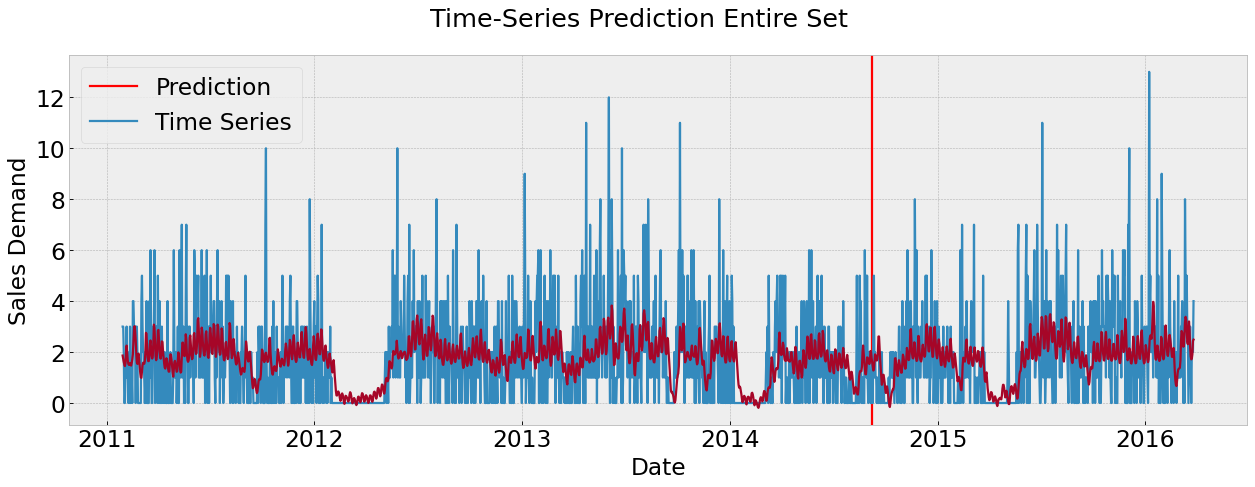

In [55]:
# Load the best model's weights
lstm.load_state_dict(torch.load('best_model.pt'))

# Set the model to evaluation mode
lstm.eval()
with torch.no_grad():
    # Make predictions on the entire dataset
    train_predict = lstm(dataX.to(device))
    data_predict = train_predict.cpu().data.numpy()
    dataY_plot = dataY.data.numpy()
    print(data_predict.shape)
    print(dataY_plot.shape)

## Inverse Normalize 
# Inverse normalize the predicted and actual data using the respective scalers
data_predict = y_scaler.inverse_transform(data_predict)
dataY_plot = y_scaler.inverse_transform(dataY_plot.reshape(-1, 1))

## Add dates
# Create DataFrames with predictions and labels, setting dates as the index
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot the results
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

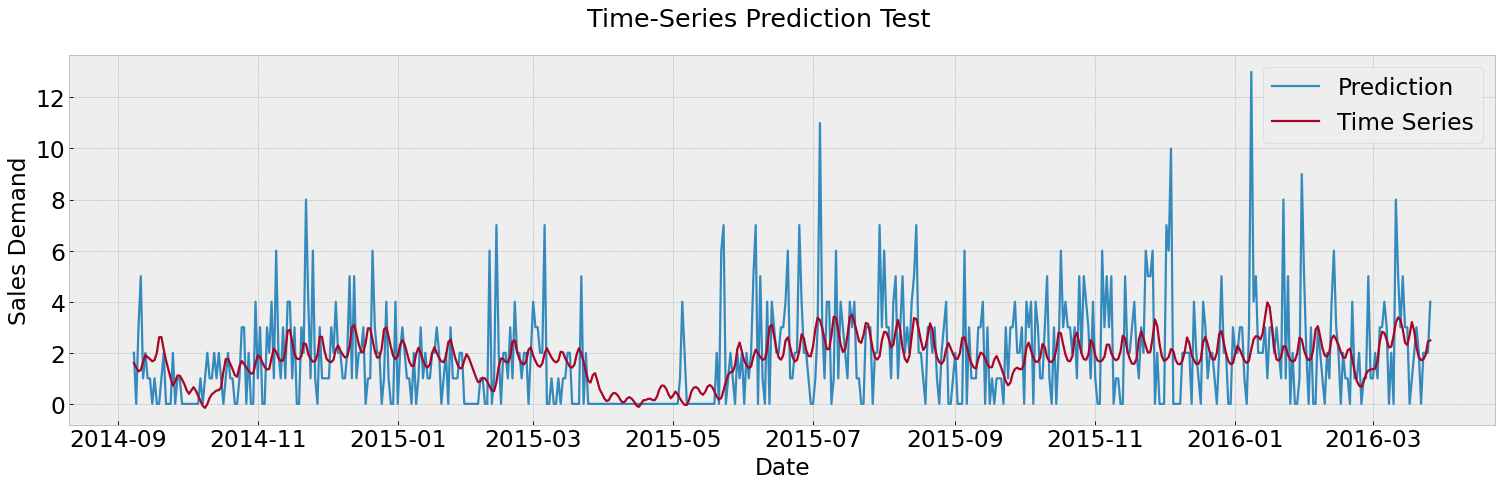

In [56]:
#Plot Test Set
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

<h2 style="background-color:lightpink; color:black" > Calculate Performance Metrics</h2>

In [57]:
# Calculate RMSE
rmse_final = np.sqrt(mean_squared_error(dataY_plot[-testX.size()[0]:], data_predict[-testX.size()[0]:]))

# Calculate R^2
r2_final = r2_score(dataY_plot[-testX.size()[0]:], data_predict[-testX.size()[0]:])

# Calculate MAE
mae_final = mean_absolute_error(dataY_plot[-testX.size()[0]:], data_predict[-testX.size()[0]:])

# Create a DataFrame
results_final = pd.DataFrame({'Metric': ['RMSE', 'R^2', 'MAE'],
                            'Value': [rmse_final, r2_final, mae_final]})

# Display the DataFrame
results_final

,Metric,Value
0,RMSE,1.787155
1,R^2,0.143813
2,MAE,1.295920


# Hyperparameter Tuning

In [58]:
# Calculate the training size as 50% of the total data length
train_size = int(len(y) * 0.80)

# Calculate the test size as the remaining data points
test_size = len(y) - train_size

# Convert the input features (x) and labels (y) into PyTorch Variables
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

# Extract the training features and labels from the data
trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

# Extract the test features and labels from the data
testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

# Print the shapes of the training and testing sets
print("train shape is:", trainX.size())
print("train label shape is:", trainY.size())
print("test shape is:", testX.size())
print("test label shape is:", testY.size())

train shape is: torch.Size([1507, 28, 18])
train label shape is: torch.Size([1507, 1])
test shape is: torch.Size([377, 28, 18])
test label shape is: torch.Size([377, 1])


In [59]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define a list of optimizers to test
optimizers_to_test = [
    optim.SGD,
    optim.Adam,
    optim.RMSprop,
    optim.Adagrad,
    optim.Adadelta,
    optim.AdamW,
    
]
# Define a larger hyperparameter search space
learning_rate_range = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]  # Expanded learning rate range
hidden_size_range = [64, 128, 256, 512, 1024]  # Expanded hidden size range
num_layers_range = [1, 2, 3, 4, 5]  # Expanded number of layers range
l2_strength_range = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]  # Expanded L2 strength range

# Number of random combinations to try
num_random_combinations = 10

# Initialize the best validation loss to a high value
best_validation_loss = 100


# Initialize variables to store the best hyperparameters and corresponding metrics
best_hyperparameters = None
best_metrics = {
    'mae': float('inf'),  # Initialize with positive infinity
    'r2': -1,             # Initialize with negative infinity
    'rmse': float('inf')  # Initialize with positive infinity
}

# Define the number of epochs and other training settings
num_epochs = 500
patience = 100
no_improvement_epochs = 0
best_val_loss = float('inf')

# Perform Random Search
for iteration in range(num_random_combinations):
    print(f"Starting iteration {iteration + 1}/{num_random_combinations}")
    # Randomly sample hyperparameters
    learning_rate = random.choice(learning_rate_range)
    hidden_size = random.choice(hidden_size_range)
    num_layers = random.choice(num_layers_range)
    l2_strength = random.choice(l2_strength_range)
    
    # Randomly select an optimizer from the list
    optimizer_class = random.choice(optimizers_to_test)

    # Create an instance of the LSTM_Final model with the sampled hyperparameters
    lstm = LSTM_Final(num_classes, input_size, hidden_size, num_layers)
    lstm.to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss().to(device)
    optimizer = optimizer_class(lstm.parameters(), lr=learning_rate, weight_decay=l2_strength)
    
    # Define the scheduler
    scheduler = ReduceLROnPlateau(optimizer, patience=50, factor=0.5, min_lr=1e-7, eps=1e-08)

    # Training and evaluation code
    for epoch in range(num_epochs):
        # Set the model to training mode
        lstm.train()

        # Perform a forward pass and compute the loss
        outputs = lstm(trainX.to(device))
        optimizer.zero_grad()
        nn.utils.clip_grad_norm_(lstm.parameters(), 1)  # Apply gradient clipping
        loss = criterion(outputs, trainY.to(device))

        # Backpropagate the loss and update model parameters
        loss.backward()
        optimizer.step()

        # Set the model to evaluation mode
        lstm.eval()

        # Compute validation loss without gradient computation
        with torch.no_grad():
            valid = lstm(testX.to(device))
            val_loss = criterion(valid, testY.to(device))
            scheduler.step(val_loss)  # Adjust learning rate based on validation loss
            
            # Calculate R2 and MAE
            y_true = testY.cpu().numpy()
            y_pred = valid.cpu().numpy()
            r2 = r2_score(y_true, y_pred)
            mae = mean_absolute_error(y_true, y_pred)
            scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        # Save the best model if the current validation loss is lower
        if val_loss.cpu().item() < best_val_loss:
            torch.save(lstm.state_dict(), 'best_model.pt')
            print("Saved best model epoch:", epoch, "Validation loss:", val_loss.cpu().item())
            best_val_loss = val_loss.cpu().item()
            best_r2 = r2  # Update best R2
            best_mae = mae  # Update best MAE
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        # Early stopping: Check if the training should stop
        if no_improvement_epochs >= patience:
            print("Early stopping after", epoch, "epochs without improvement.")
            break

        # Print progress at regular intervals
        if epoch % 50 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print("Epoch: %d, Training loss: %1.5f, Validation loss: %1.5f, Learning rate: %1.7f" % (epoch, loss.cpu().item(), val_loss.cpu().item(), current_lr))

    # Check if this combination resulted in a better validation loss
    if val_loss.cpu().item() < best_validation_loss:
        best_validation_loss = val_loss.cpu().item()
        # Initialize variables to store the best hyperparameters for R2 and MAE
        best_hyperparameters = {
            'learning_rate': learning_rate,
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'l2_strength': l2_strength,
            'optimizer': optimizer_class.__name__  # Store optimizer name
        }

Starting iteration 1/10
Saved best model epoch: 0 Validation loss: 0.03486371412873268
Epoch: 0, Training loss: 0.24371, Validation loss: 0.03486, Learning rate: 0.0100000
Saved best model epoch: 1 Validation loss: 0.03287047892808914
Saved best model epoch: 5 Validation loss: 0.03141840919852257
Saved best model epoch: 6 Validation loss: 0.026319919154047966
Saved best model epoch: 7 Validation loss: 0.025648051872849464
Saved best model epoch: 8 Validation loss: 0.02505464293062687
Saved best model epoch: 9 Validation loss: 0.02501249685883522
Saved best model epoch: 30 Validation loss: 0.025010759010910988
Saved best model epoch: 31 Validation loss: 0.024949567392468452
Saved best model epoch: 32 Validation loss: 0.024931810796260834
Saved best model epoch: 33 Validation loss: 0.024846771731972694
Saved best model epoch: 34 Validation loss: 0.024767566472291946
Saved best model epoch: 36 Validation loss: 0.02474568784236908
Saved best model epoch: 37 Validation loss: 0.0247186534106

C:\Anaconda\envs\tf\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Early stopping after 0 epochs without improvement.
Starting iteration 8/10
Early stopping after 0 epochs without improvement.
Starting iteration 9/10
Early stopping after 0 epochs without improvement.
Starting iteration 10/10
Early stopping after 0 epochs without improvement.


In [60]:
# Print the best hyperparameters and metrics
print("Best Hyperparameters:")
print(best_hyperparameters)

Best Hyperparameters:
{'learning_rate': 0.01, 'hidden_size': 128, 'num_layers': 3, 'l2_strength': 0.001, 'optimizer': 'Adagrad'}


# Training Model with Refined Hyperparameters

In [66]:
# Set hyperparameters
num_epochs = 500
learning_rate = 0.01
input_size = 18
hidden_size = 128
num_layers = 3
num_classes = 1
l2_strength = 0.001

# Initialize the best validation loss to a high value
best_val_loss = 500

# Create an instance of the LSTM_Final model
lstm = LSTM_Final(num_classes, input_size, hidden_size, num_layers)

# Move the model to the specified device (e.g., GPU)
lstm.to(device)

# Apply weight initialization to the model
lstm.apply(init_weights)

# Define the loss function (mean squared error) and optimizer (Adam)
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adagrad(lstm.parameters(), lr=learning_rate, weight_decay=l2_strength)

# Set up a learning rate scheduler with patience and minimum learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5, min_lr=1e-7, eps=1e-08)

# Training loop
patience = 100  # Number of epochs to wait for early stopping
no_improvement_epochs = 0  # Counter for early stopping

for epoch in progress_bar(range(num_epochs)):
    # Set the model to training mode
    lstm.train()
    
    # Perform a forward pass and compute the loss
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)  # Apply gradient clipping
    loss = criterion(outputs, trainY.to(device))
    
    # Backpropagate the loss and update model parameters
    loss.backward()
    optimizer.step()
    
    # Set the model to evaluation mode
    lstm.eval()
    
    # Compute validation loss without gradient computation
    with torch.no_grad():
        valid = lstm(testX.to(device))
        vall_loss = criterion(valid, testY.to(device))
        scheduler.step(vall_loss)  # Adjust learning rate based on validation loss
    
    # Save the best model if the current validation loss is lower
    if vall_loss.cpu().item() < best_val_loss:
        torch.save(lstm.state_dict(), 'best_model.pt')
        print("Saved best model epoch:", epoch, "Validation loss:", vall_loss.cpu().item())
        best_val_loss = vall_loss.cpu().item()
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1
    
     # Early stopping: Check if the training should stop
    if no_improvement_epochs >= patience:
        print("Early stopping after", epoch, "epochs without improvement.")
        break
    
    # Print progress at regular intervals
    if epoch % 50 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print("Epoch: %d, Training loss: %1.5f, Validation loss: %1.5f, Learning rate: %1.7f" % (epoch, loss.cpu().item(), vall_loss.cpu().item(), current_lr))

Saved best model epoch: 0 Validation loss: 0.026450779289007187
Epoch: 0, Training loss: 0.02413, Validation loss: 0.02645, Learning rate: 0.0100000
Saved best model epoch: 17 Validation loss: 0.02642938680946827
Saved best model epoch: 19 Validation loss: 0.026402177289128304
Saved best model epoch: 21 Validation loss: 0.02634107694029808
Saved best model epoch: 23 Validation loss: 0.02633257396519184
Saved best model epoch: 24 Validation loss: 0.026295138522982597
Saved best model epoch: 26 Validation loss: 0.026242932304739952
Saved best model epoch: 28 Validation loss: 0.026199303567409515
Saved best model epoch: 31 Validation loss: 0.026165056973695755
Saved best model epoch: 33 Validation loss: 0.026116879656910896
Saved best model epoch: 42 Validation loss: 0.026084158569574356
Saved best model epoch: 43 Validation loss: 0.026060620322823524
Saved best model epoch: 44 Validation loss: 0.02601701207458973
Saved best model epoch: 45 Validation loss: 0.02596624381840229
Saved best 

(1884, 1)
(1884, 1)


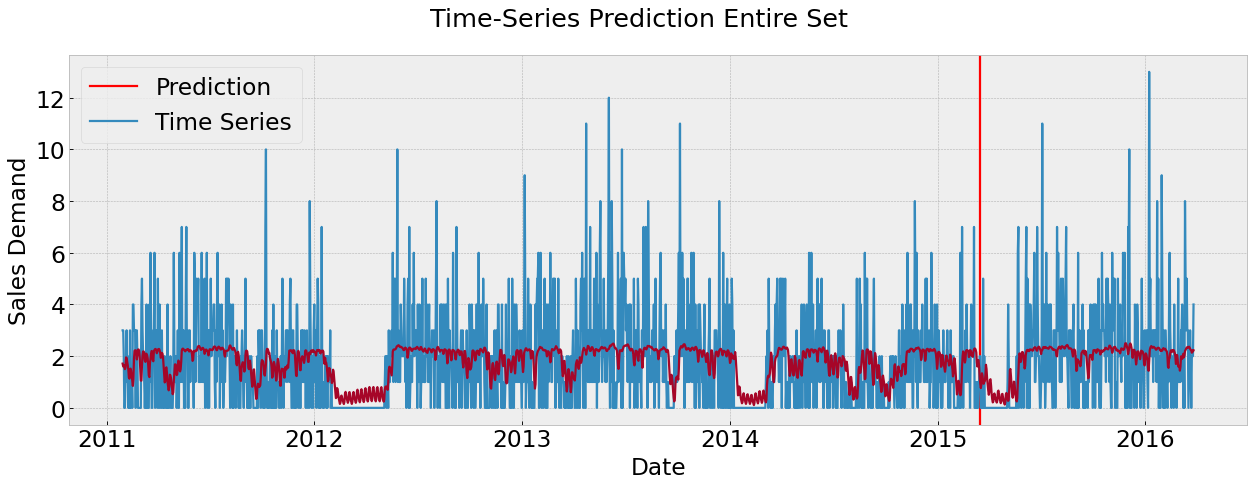

In [70]:
# Load the best model's weights
lstm.load_state_dict(torch.load('best_model.pt'))

# Set the model to evaluation mode
lstm.eval()
with torch.no_grad():
    # Make predictions on the entire dataset
    train_predict = lstm(dataX.to(device))
    data_predict = train_predict.cpu().data.numpy()
    dataY_plot = dataY.data.numpy()
    print(data_predict.shape)
    print(dataY_plot.shape)

## Inverse Normalize 
# Inverse normalize the predicted and actual data using the respective scalers
data_predict = y_scaler.inverse_transform(data_predict)
dataY_plot = y_scaler.inverse_transform(dataY_plot.reshape(-1, 1))

## Add dates
# Create DataFrames with predictions and labels, setting dates as the index
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot the results
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [71]:
# Calculate RMSE
rmse_final2 = np.sqrt(mean_squared_error(dataY_plot[-testX.size()[0]:], data_predict[-testX.size()[0]:]))

# Calculate R^2
r2_final2 = r2_score(dataY_plot[-testX.size()[0]:], data_predict[-testX.size()[0]:])

# Calculate MAE
mae_final2 = mean_absolute_error(dataY_plot[-testX.size()[0]:], data_predict[-testX.size()[0]:])

# Create a DataFrame
results_final2 = pd.DataFrame({'Metric': ['RMSE', 'R^2', 'MAE'],
                            'Value': [rmse_final2, r2_final2, mae_final2]})

# Display the DataFrame
results_final2

,Metric,Value
0,RMSE,1.937212
1,R^2,0.123949
2,MAE,1.417956


# Comparing Results <a id="11"></a> 

In [64]:
# Create a dictionary to label each set of results
results_dict = {'Single Layer': results_singleLayer, 
                'Multi-Layer': results_multiLayer, 
                'Final': results_final,
                'Final Refined' : results_final2}

# Concatenate the DataFrames horizontally (along columns)
compare_results = pd.concat(results_dict, axis=1)

In [65]:
compare_results

Single Layer           Multi-Layer            Final           Final Refined  \
        Metric     Value      Metric     Value Metric     Value        Metric   
0         RMSE  1.878877        RMSE  1.837196   RMSE  1.787155          RMSE   
1          R^2  0.053674         R^2  0.095194    R^2  0.143813           R^2   
2          MAE  1.329708         MAE  1.347971    MAE  1.295920           MAE   

             
      Value  
0  1.956780  
1  0.106161  
2  1.412472